# Demonstration of InvGPNet models
#### 2 vs 3, images are rotated randomly $-180\sim 180$ degrees
#### Train models for 10000 iterations for demo

In [2]:
import tensorflow as tf
import numpy as np
import gpflow
from gpflow.config import default_jitter
from tensorflow import linalg as tfla

# Creating rotated MNIST 2 vs 3

In [17]:
def load_mnist(digits=[2, 3]):
    mnist = tf.keras.datasets.mnist.load_data()
    full_X_train, full_X_test = [x[0].reshape(-1, 28 * 28).astype(gpflow.config.default_float()) / 255.0
                                 for x in mnist]
    full_Y_train, full_Y_test = [x[1].reshape(-1, 1).astype(gpflow.config.default_int())
                                 for x in mnist]
    select_train = np.isin(full_Y_train[:, 0], digits)
    X, Y = [x[select_train, :] for x in [full_X_train, full_Y_train]]
    select_test = np.isin(full_Y_test[:, 0], digits)
    Xt, Yt = [x[select_test, :] for x in [full_X_test, full_Y_test]]
    return (X, Y), (Xt, Yt)

(X_train,Y_train),(X_test,Y_test)=load_mnist()
Y_train = np.eye(10)[Y_train[:, 0]][:,2:4].astype(gpflow.config.default_float())
Y_test = np.eye(10)[Y_test[:, 0]][:,2:4].astype(gpflow.config.default_float())
np.random.seed(1)
random_perm = np.random.permutation(len(X_train))
#X = X_train[random_perm[:1000], :]
#Y = Y_train[random_perm[:1000], :] 
X = X_train[random_perm[:5000], :]
Y = Y_train[random_perm[:5000], :] 
Xt = X_train[random_perm[5000:6000], :]
Yt = Y_train[random_perm[5000:6000], :]

In [18]:
from Original.kernels.image_transforms import rotate_img_angles, rotate_img_angles_stn, apply_stn_batch, _stn_theta_vec, \
    apply_stn_batch_colour
X2=[]
for i in range(X.shape[0]):
    angle=-360*np.random.rand((1))+180
    Ximg=np.reshape(X[i], [-1, 28, 28])
    Ximg2=rotate_img_angles(Ximg, angle, "Nearest")
    X2=np.append(X2,Ximg2.numpy().reshape(-1, X.shape[1]))
X2=X2.reshape(-1,X.shape[1])
print(X2.shape)
Y2=Y
Xt2=[]
for i in range(Xt.shape[0]):
    angle=-360*np.random.rand((1))+180
    Xtimg=np.reshape(Xt[i], [-1, 28, 28])
    Xtimg2=rotate_img_angles(Xtimg, angle, "Nearest")
    Xt2=np.append(Xt2,Xtimg2.numpy().reshape(-1, Xt.shape[1]))
Xt2=Xt2.reshape(-1,Xt.shape[1])
print(Xt2.shape)
Yt2=Yt

(5000, 784)
(1000, 784)


# Necessary functions

In [5]:
def multivariate_normal_kl(q_mean,q_cov_tril,p_mean,p_cov_tril, dtype=tf.float64):
    # return KL(q, p)
    kl = -0.5 * tf.cast(tf.shape(q_mean)[-1], dtype)
    kl -= tf.reduce_sum(tf.math.log(tfla.diag_part(q_cov_tril)), axis=-1)
    kl += tf.reduce_sum(tf.math.log(tfla.diag_part(p_cov_tril)), axis=-1)
    p_inv_q = tfla.triangular_solve(p_cov_tril, q_cov_tril, lower=True)
    kl += 0.5 * tf.reduce_sum(tf.math.square(p_inv_q), axis=(-1, -2))
    Kinv_m = tfla.cholesky_solve(p_cov_tril, tf.expand_dims(q_mean - p_mean, -1))
    kl += 0.5 * tf.reduce_sum((q_mean - p_mean) * tf.squeeze(Kinv_m, -1),axis=-1)
    return kl

def multivariate_normal_entropy(p_mean,p_cov_tril, dtype=tf.float64):
    d = tf.cast(tf.shape(p_mean)[-1], dtype)
    ret = 0.5 * d * tf.math.log(2 * tf.constant(np.pi, dtype))
    ret += tf.reduce_sum(tf.math.log(tfla.diag_part(p_cov_tril)), axis=-1)
    ret += 0.5 * d
    return ret


def multivariate_normal_cross_entropy(p_mean,p_cov_tril, q_mean,q_cov_tril, dtype=tf.float64):
    d = tf.cast(tf.shape(p_mean)[-1], dtype)
    ret = 0.5 * d * tf.math.log(2 * tf.constant(np.pi, dtype))
    ret += tf.reduce_sum(tf.math.log(tfla.diag_part(q_cov_tril)), axis=-1)
    q_inv_p = tfla.triangular_solve(q_cov_tril, p_cov_tril, lower=True)
    ret += 0.5 * tf.reduce_sum(tf.math.square(q_inv_p), axis=(-1, -2))
    Kinv_m = tfla.cholesky_solve(q_cov_tril, tf.expand_dims(p_mean - q_mean, -1))
    ret += 0.5 * tf.reduce_sum((p_mean - q_mean) * tf.squeeze(Kinv_m, -1),axis=-1)
    return ret

# Define non-invariant model

In [12]:
tf.keras.backend.set_floatx('float64')
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, n_out, n_in, **kwargs):
        super().__init__(**kwargs)
        self.n_out=n_out
        self.n_in=n_in
        
        self.w=tf.Variable(tf.random.truncated_normal([self.n_in,self.n_out],stddev=0.01,dtype=tf.float64),dtype=tf.float64)
        
        self.w_cov_raw=tf.Variable(tf.eye(self.n_in,dtype=tf.float64),dtype=tf.float64)
        
    def call(self,inputs):
        w_cov_tril=tfla.set_diag(tfla.band_part(self.w_cov_raw,-1,0),tf.math.softplus(tfla.diag_part(self.w_cov_raw)))
        f_mean=tf.matmul(inputs,self.w)
        f_cov_half=tf.matmul(inputs,w_cov_tril)
        return f_mean, f_cov_half, w_cov_tril
    
class CustomConv(tf.keras.layers.Layer):
    def __init__(self,n_filt, **kwargs):
        super().__init__(**kwargs)
        self.n_filt=n_filt
        
        self.w=tf.Variable(tf.random.truncated_normal([self.n_filt,28*28],stddev=0.01,dtype=tf.float64),dtype=tf.float64)
        self.b=tf.Variable(tf.zeros([self.n_filt],dtype=tf.float64),dtype=tf.float64)
        
    def call(self,inputs):
        h=tf.tensordot(inputs,self.w,((1),(1)))+self.b
        return tf.keras.activations.tanh(h)
    
    
class NN(tf.keras.Model):
    def __init__(self,n_filter,n_cls,mvn=True, **kwargs):
        super().__init__(**kwargs)
        self.n_cls=n_cls
        self.mvn=mvn
        self.n_filter=n_filter
        self.conv=CustomConv(self.n_filter)
        self.dense=CustomDense(self.n_cls,self.n_filter)

      
    @tf.function
    def  call(self,x,full_cov=True):
        batch_size = tf.shape(x)[0]
        x=tf.dtypes.cast(x,tf.float64)
        
        h=self.conv(x)
        
        f_mean, f_cov_half, w_cov_tril =self.dense(h)
        
        f_mean=tf.transpose(f_mean)
        
        if full_cov:
            f_cov=tf.matmul(f_cov_half,f_cov_half,transpose_b=True)
            f_cov = f_cov + tf.eye(tf.shape(f_cov)[1], dtype=tf.float64)*default_jitter()
            f_cov=tf.broadcast_to(f_cov,[self.n_cls,f_cov.shape[0],f_cov.shape[1]])
            if self.mvn:
                f_cov_tril = tfla.cholesky(f_cov)
                return f_mean, f_cov_tril
            else:
                return f_mean, f_cov
        else:
            f_var=tf.reduce_sum(tf.square(f_cov_half),axis=-1)
            f_var = f_var + default_jitter()
            return f_mean, f_var

In [13]:
class training_model():
    def __init__(self,x_train,y_train,x_test,y_test,data_batch_size, measure_batch_size,kernel,
                 likelihood, n_filter, learning_rate, hyper_rate, beta0, gamma, n_iters):
        self.data_batch_size=data_batch_size
        self.measure_batch_size=measure_batch_size
        self.kernel=kernel
        self.likelihood=likelihood
        self.n_filter=n_filter
        self.learning_rate=learning_rate
        self.hyper_rate=hyper_rate
        self.beta=beta0
        self.gamma=gamma
        self.n_iter=n_iters
        self.n_cls=y_train.shape[1]
        self.bnn_prev=NN(self.n_filter,self.n_cls,mvn=False)
        self.bnn=NN(self.n_filter,self.n_cls)
        self.x_test=x_test
        self.y_test=y_test
        self.x_train=x_train
        self.y_train=y_train
        self.create_batch=(self.x_train,self.y_train)
        self.N=self.x_train.shape[0]

          
    def kl_objective(self,train_x,measure_x,train_y):
        n=train_x.shape[0]
        xx = tf.concat([train_x, measure_x], axis=0)
        
        self.qf_star, self.qf_cov_tril = self.bnn(xx)
        self.qff_mean_prev, self.K_prox = self.bnn_prev(xx)
        self.qf_mean, self.qf_var = self.bnn(train_x, full_cov=False)
        
        ######
        f_pred = self.qf_mean + tf.math.sqrt(self.qf_var) * tf.random.normal(tf.shape(self.qf_mean),dtype=tf.float64)
    
       
        K_prior = self.kernel.K(xx,xx)
        K_prior_tril = tfla.cholesky(K_prior + tf.eye(tf.shape(xx)[0], dtype=tf.float64) *  default_jitter())

        # likelihood term
        f_term = -tf.nn.softmax_cross_entropy_with_logits(labels=train_y,logits=tf.transpose(f_pred))
        f_term = tf.reduce_sum(f_term)
        f_term *= self.N / tf.cast(n, tf.float64) * self.beta

       # prior term
        prior_term = -self.beta * tf.reduce_sum(multivariate_normal_cross_entropy(self.qf_star, self.qf_cov_tril,tf.zeros([self.n_cls, tf.shape(xx)[0]], dtype=tf.float64),tf.tile(K_prior_tril[None, ...], [self.n_cls, 1, 1])))

       # proximity term
        prox_term = -(1 - self.beta) * tf.reduce_sum(multivariate_normal_cross_entropy(self.qf_star, self.qf_cov_tril,self.qff_mean_prev,tfla.cholesky(self.K_prox)))


       # entropy term
        entropy_term = tf.reduce_sum(multivariate_normal_entropy(self.qf_star, self.qf_cov_tril)) 
        lower_bound = f_term + prior_term + prox_term + entropy_term
        
        return -lower_bound
    
    def hyper_objective(self,train_x,measure_x,train_y):
        n=train_x.shape[0]
        xx = tf.concat([train_x, measure_x], axis=0)
        self.yf = tf.cast(tf.transpose(train_y), dtype=tf.float64)
        
        self.K_prior = self.kernel.K(xx,xx) + tf.eye(tf.shape(xx)[0], dtype=tf.float64) * default_jitter()
        self.qff_mean_prev, self.K_prox = self.bnn_prev(xx)
            
        Kn_prior = tf.tile(self.K_prior[None, :n, :n], [self.n_cls, 1, 1])
 
        Kn_prox = self.K_prox[:, :n, :n]
        qf_prev_mean = self.qff_mean_prev[:, :n]
        qf_prev_var = tfla.diag_part(Kn_prox)
        
        scale = self.N / n
 
        hyper_obj = tf.reduce_sum(self.likelihood.variational_expectations(qf_prev_mean, qf_prev_var, self.yf))*scale - tf.reduce_sum(
            multivariate_normal_kl(qf_prev_mean, tfla.cholesky(Kn_prox),tf.zeros([self.n_cls, n], dtype=tf.float64),tfla.cholesky(Kn_prior)))
    
        return -hyper_obj
        
    
    @tf.function
    def kl_step(self,train_x,measure_x,train_y):
        with tf.GradientTape(persistent=False) as tape:
            kl_obj=self.kl_objective(train_x,measure_x,train_y)
        gradients=tape.gradient(kl_obj, self.bnn.trainable_variables)
        self.gpnet_optimizer.apply_gradients(zip(gradients,self.bnn.trainable_variables))
        
    @tf.function
    def hyper_step(self,train_x,measure_x,train_y):
        with tf.GradientTape(persistent=True) as tape:
            hyper_obj=self.hyper_objective(train_x,measure_x,train_y)
        gradients=tape.gradient(hyper_obj, self.kernel.trainable_variables)
        self.hyper_optimizer.apply_gradients(zip(gradients,self.kernel.trainable_variables))
        gradients=tape.gradient(hyper_obj, self.likelihood.trainable_variables)
        self.hyper_optimizer.apply_gradients(zip(gradients,self.likelihood.trainable_variables))

    
    
    def train(self):
        self.gpnet_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.hyper_optimizer = tf.keras.optimizers.Adam(learning_rate=self.hyper_rate)
        
        batch_size=self.data_batch_size+self.measure_batch_size
        train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
        train_dataset = train_dataset.shuffle(self.x_train.shape[0]).batch(batch_size)
        train_iter=iter(train_dataset.repeat())
        
        sample_x,sample_y=next(train_iter)
        self.bnn(sample_x)
        accuracy=[]
        
        for i in range(1,self.n_iter+1):
            self.beta = self.beta * 1. / (1. + self.gamma * np.sqrt(i - 1))
            
            sample_x,sample_y=next(train_iter)
            random_perm = np.random.permutation(len(sample_x))

            n=self.data_batch_size
            train_x = tf.gather(sample_x,random_perm[:n])
            train_y = tf.gather(sample_y,random_perm[:n])
            measure_x = tf.gather(sample_x,random_perm[n:])
            measure_y = tf.gather(sample_y,random_perm[n:])
            
            bnn_weight=self.bnn.get_weights()
            
            
            self.kl_step(train_x,measure_x,train_y)
            #self.hyper_step(train_x,measure_x,train_y)

            self.bnn_prev.set_weights(bnn_weight)
            print("Iter {}, lenthscale {}".format(i,self.kernel.lengthscales.numpy()))
            
            if i%100==0:
                qf_mean, qf_var = self.bnn(self.x_test, full_cov=False)    
                # y_pred: [bs]
                y_pred = tf.math.argmax(qf_mean, axis=0, output_type=tf.int32)
                # y_target: [bs]
                y_target = tf.math.argmax(self.y_test, axis=1, output_type=tf.int32)
                # acc: []
                acc = (1-tf.reduce_mean(tf.cast(tf.math.equal(y_pred, y_target),dtype=tf.float32)))*100
                accuracy.append(acc.numpy())
                print("test_acc {}".format(acc))
        return accuracy,self.bnn


# Define invariant model

In [14]:
tf.keras.backend.set_floatx('float64')
class CustomDense2(tf.keras.layers.Layer):
    def __init__(self, n_out, n_in, **kwargs):
        super().__init__(**kwargs)
        self.n_out=n_out
        self.n_in=n_in
        
        self.w=tf.Variable(tf.random.truncated_normal([self.n_in,self.n_out],stddev=0.01,dtype=tf.float64),dtype=tf.float64)
        
        self.w_cov_raw=tf.Variable(tf.eye(self.n_in,dtype=tf.float64),dtype=tf.float64)
    def call(self,inputs):
        w_cov_tril=tfla.set_diag(tfla.band_part(self.w_cov_raw,-1,0),tf.math.softplus(tfla.diag_part(self.w_cov_raw)))
        f_mean=tf.matmul(inputs,self.w)
        f_cov_half=tf.matmul(inputs,w_cov_tril)
        return f_mean, f_cov_half, w_cov_tril
    
class CustomConv2(tf.keras.layers.Layer):
    def __init__(self,n_filt, orbit_size,kernel,**kwargs):
        super().__init__(**kwargs)
        self.n_filt=n_filt
        self.orbit_size=orbit_size
        self.kernel=kernel
        
        self.w=tf.Variable(tf.random.truncated_normal([self.n_filt,28*28],stddev=0.01,dtype=tf.float64),dtype=tf.float64)
        self.b=tf.Variable(tf.zeros([self.n_filt],dtype=tf.float64),dtype=tf.float64)
        
    def call(self,inputs):        
        Rotated_w=self.kernel.orbit(self.w)
        Rotated_w=tf.reshape(Rotated_w,[-1,Rotated_w.shape[2]])
        
        h=tf.tensordot(inputs,Rotated_w,((1),(1)))+tf.repeat(self.b,self.orbit_size)
        h=tf.keras.activations.tanh(h)
        h=tf.reshape(h,[inputs.shape[0],self.n_filt,self.orbit_size])
        
        h=tf.reduce_mean(h,axis=2)
        return h
    
    
class NN2(tf.keras.Model):
    def __init__(self,n_filter,n_cls,orbit_size,kernel,mvn=True, **kwargs):
        super().__init__(**kwargs)
        self.n_cls=n_cls
        self.mvn=mvn
        self.n_filter=n_filter
        self.orbit_size=orbit_size
        self.kernel=kernel
        self.conv=CustomConv2(self.n_filter,self.orbit_size,self.kernel)
        self.dense=CustomDense2(self.n_cls,self.n_filter)

      
    @tf.function
    def  call(self,x,full_cov=True):
        batch_size = tf.shape(x)[0]
        x=tf.dtypes.cast(x,tf.float64)
        
        h=self.conv(x)
        
        f_mean, f_cov_half, w_cov_tril =self.dense(h)
        
        f_mean=tf.transpose(f_mean)
        
        if full_cov:
            f_cov=tf.matmul(f_cov_half,f_cov_half,transpose_b=True)
            f_cov = f_cov + tf.eye(tf.shape(f_cov)[1], dtype=tf.float64)*default_jitter()
            f_cov=tf.broadcast_to(f_cov,[self.n_cls,f_cov.shape[0],f_cov.shape[1]])
            if self.mvn:
                f_cov_tril = tfla.cholesky(f_cov)
                return f_mean, f_cov_tril
            else:
                return f_mean, f_cov
        else:
            f_var=tf.reduce_sum(tf.square(f_cov_half),axis=-1)
            f_var = f_var + default_jitter()
            return f_mean, f_var

In [15]:
class training_model2():
    def __init__(self,x_train,y_train,x_test,y_test,data_batch_size, measure_batch_size,kernel,
                 likelihood, orbit_size, n_filter, learning_rate, hyper_rate, beta0, gamma, n_iters):
        self.data_batch_size=data_batch_size
        self.measure_batch_size=measure_batch_size
        self.kernel=kernel
        self.likelihood=likelihood
        self.orbit_size=orbit_size
        self.n_filter=n_filter
        self.learning_rate=learning_rate
        self.hyper_rate=hyper_rate
        self.beta=beta0
        self.gamma=gamma
        self.n_iter=n_iters
        self.n_cls=y_train.shape[1]
        self.bnn_prev=NN2(self.n_filter,self.n_cls,self.orbit_size,self.kernel,mvn=False)
        self.bnn=NN2(self.n_filter,self.n_cls,self.orbit_size,self.kernel)
        self.x_test=x_test
        self.y_test=y_test
        self.x_train=x_train
        self.y_train=y_train
        self.create_batch=(self.x_train,self.y_train)
        self.N=self.x_train.shape[0]

          
    def kl_objective(self,train_x,measure_x,train_y):
        n=train_x.shape[0]
        xx = tf.concat([train_x, measure_x], axis=0)
        
        self.qf_star, self.qf_cov_tril = self.bnn(xx)
        self.qff_mean_prev, self.K_prox = self.bnn_prev(xx)
        self.qf_mean, self.qf_var = self.bnn(train_x, full_cov=False)
        
        ######
        f_pred = self.qf_mean + tf.math.sqrt(self.qf_var) * tf.random.normal(tf.shape(self.qf_mean),dtype=tf.float64)
    
       
        K_prior = self.kernel.K(xx,xx)
        K_prior_tril = tfla.cholesky(K_prior + tf.eye(tf.shape(xx)[0], dtype=tf.float64) *  default_jitter())

        # likelihood term
        f_term = -tf.nn.softmax_cross_entropy_with_logits(labels=train_y,logits=tf.transpose(f_pred))
        f_term = tf.reduce_sum(f_term)
        f_term *= self.N / tf.cast(n, tf.float64) * self.beta

       # prior term
        prior_term = -self.beta * tf.reduce_sum(multivariate_normal_cross_entropy(self.qf_star, self.qf_cov_tril,tf.zeros([self.n_cls, tf.shape(xx)[0]], dtype=tf.float64),tf.tile(K_prior_tril[None, ...], [self.n_cls, 1, 1])))

       # proximity term
        prox_term = -(1 - self.beta) * tf.reduce_sum(multivariate_normal_cross_entropy(self.qf_star, self.qf_cov_tril,self.qff_mean_prev,tfla.cholesky(self.K_prox)))


       # entropy term
        entropy_term = tf.reduce_sum(multivariate_normal_entropy(self.qf_star, self.qf_cov_tril)) 
        lower_bound = f_term + prior_term + prox_term + entropy_term
        
        return -lower_bound
    
    def hyper_objective(self,train_x,measure_x,train_y):
        n=train_x.shape[0]
        xx = tf.concat([train_x, measure_x], axis=0)
        self.yf = tf.cast(tf.transpose(train_y), dtype=tf.float64)
        
        self.K_prior = self.kernel.K(xx,xx) + tf.eye(tf.shape(xx)[0], dtype=tf.float64) * default_jitter()
        self.qff_mean_prev, self.K_prox = self.bnn_prev(xx)            
        Kn_prior = tf.tile(self.K_prior[None, :n, :n], [self.n_cls, 1, 1])
 
        Kn_prox = self.K_prox[:, :n, :n]
        qf_prev_mean = self.qff_mean_prev[:, :n]
        qf_prev_var = tfla.diag_part(Kn_prox)
        
        scale = self.N / n
 
        hyper_obj = tf.reduce_sum(self.likelihood.variational_expectations(qf_prev_mean, qf_prev_var, self.yf))*scale - tf.reduce_sum(
            multivariate_normal_kl(qf_prev_mean, tfla.cholesky(Kn_prox),tf.zeros([self.n_cls, n], dtype=tf.float64),tfla.cholesky(Kn_prior)))
    
        return -hyper_obj
        
    
    @tf.function
    def kl_step(self,train_x,measure_x,train_y):
        with tf.GradientTape(persistent=False) as tape:
            kl_obj=self.kl_objective(train_x,measure_x,train_y)
        gradients=tape.gradient(kl_obj, self.bnn.trainable_variables)
        self.gpnet_optimizer.apply_gradients(zip(gradients,self.bnn.trainable_variables))
        
    @tf.function
    def hyper_step(self,train_x,measure_x,train_y):
        with tf.GradientTape(persistent=False) as tape:
            hyper_obj=self.hyper_objective(train_x,measure_x,train_y)
        gradients=tape.gradient(hyper_obj, self.kernel.orbit.trainable_variables)
        self.hyper_optimizer.apply_gradients(zip(gradients,self.kernel.orbit.trainable_variables))
    
    
    def train(self):
        self.gpnet_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.hyper_optimizer = tf.keras.optimizers.Adam(learning_rate=self.hyper_rate)
        
        batch_size=self.data_batch_size+self.measure_batch_size
        train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
        train_dataset = train_dataset.shuffle(self.x_train.shape[0]).batch(batch_size)
        train_iter=iter(train_dataset.repeat())
        
        sample_x,sample_y=next(train_iter)
        self.bnn(sample_x)
        prev_angle=0
        accuracy=[]

        
        for i in range(1,self.n_iter+1):
            self.beta = self.beta * 1. / (1. + self.gamma * np.sqrt(i - 1))
            
            sample_x,sample_y=next(train_iter)
            random_perm = np.random.permutation(len(sample_x))

            n=self.data_batch_size
            train_x = tf.gather(sample_x,random_perm[:n])
            train_y = tf.gather(sample_y,random_perm[:n])
            measure_x = tf.gather(sample_x,random_perm[n:])
            measure_y = tf.gather(sample_y,random_perm[n:])
            
                
            bnn_weight=self.bnn.get_weights()

            self.kl_step(train_x,measure_x,train_y)
            #self.hyper_step(train_x,measure_x,train_y)
            

            self.bnn_prev.set_weights(bnn_weight)
            print("Iter {}, lenthscale {}".format(i,self.kernel.basekern.lengthscales.numpy()))

            
            
            if i%100==0:
                qf_mean, qf_var = self.bnn(self.x_test, full_cov=False)    
                # y_pred: [bs]
                y_pred = tf.math.argmax(qf_mean, axis=0, output_type=tf.int32)
                # y_target: [bs]
                y_target = tf.math.argmax(self.y_test, axis=1, output_type=tf.int32)
                # acc: []
                acc = (1-tf.reduce_mean(tf.cast(tf.math.equal(y_pred, y_target),dtype=tf.float32)))*100
                accuracy.append(acc.numpy())
                print("test_acc {}".format(acc))
                
        return accuracy,self.bnn
    


# Train models

In [21]:
#non-invariant model setups

learning_rate=1e-3
hyper_rate=1e-3
beta0=0.1
gamma=0.1


n_iters=10000

data_batch_size=30
measure_batch_size=30
n_filter=256*1


kernel=gpflow.kernels.SquaredExponential()
likelihood=gpflow.likelihoods.Gaussian()

train=training_model(X2,Y2,Xt2,Yt2,data_batch_size, measure_batch_size,kernel,likelihood,
                     n_filter, learning_rate, hyper_rate, beta0, gamma, n_iters)
acc1,model1=train.train()

Iter 1, lenthscale 1.0
Iter 2, lenthscale 1.0
Iter 3, lenthscale 1.0
Iter 4, lenthscale 1.0
Iter 5, lenthscale 1.0
Iter 6, lenthscale 1.0
Iter 7, lenthscale 1.0
Iter 8, lenthscale 1.0
Iter 9, lenthscale 1.0
Iter 10, lenthscale 1.0
Iter 11, lenthscale 1.0
Iter 12, lenthscale 1.0
Iter 13, lenthscale 1.0
Iter 14, lenthscale 1.0
Iter 15, lenthscale 1.0
Iter 16, lenthscale 1.0
Iter 17, lenthscale 1.0
Iter 18, lenthscale 1.0
Iter 19, lenthscale 1.0
Iter 20, lenthscale 1.0
Iter 21, lenthscale 1.0
Iter 22, lenthscale 1.0
Iter 23, lenthscale 1.0
Iter 24, lenthscale 1.0
Iter 25, lenthscale 1.0
Iter 26, lenthscale 1.0
Iter 27, lenthscale 1.0
Iter 28, lenthscale 1.0
Iter 29, lenthscale 1.0
Iter 30, lenthscale 1.0
Iter 31, lenthscale 1.0
Iter 32, lenthscale 1.0
Iter 33, lenthscale 1.0
Iter 34, lenthscale 1.0
Iter 35, lenthscale 1.0
Iter 36, lenthscale 1.0
Iter 37, lenthscale 1.0
Iter 38, lenthscale 1.0
Iter 39, lenthscale 1.0
Iter 40, lenthscale 1.0
Iter 41, lenthscale 1.0
Iter 42, lenthscale 1.0
I

Iter 345, lenthscale 1.0
Iter 346, lenthscale 1.0
Iter 347, lenthscale 1.0
Iter 348, lenthscale 1.0
Iter 349, lenthscale 1.0
Iter 350, lenthscale 1.0
Iter 351, lenthscale 1.0
Iter 352, lenthscale 1.0
Iter 353, lenthscale 1.0
Iter 354, lenthscale 1.0
Iter 355, lenthscale 1.0
Iter 356, lenthscale 1.0
Iter 357, lenthscale 1.0
Iter 358, lenthscale 1.0
Iter 359, lenthscale 1.0
Iter 360, lenthscale 1.0
Iter 361, lenthscale 1.0
Iter 362, lenthscale 1.0
Iter 363, lenthscale 1.0
Iter 364, lenthscale 1.0
Iter 365, lenthscale 1.0
Iter 366, lenthscale 1.0
Iter 367, lenthscale 1.0
Iter 368, lenthscale 1.0
Iter 369, lenthscale 1.0
Iter 370, lenthscale 1.0
Iter 371, lenthscale 1.0
Iter 372, lenthscale 1.0
Iter 373, lenthscale 1.0
Iter 374, lenthscale 1.0
Iter 375, lenthscale 1.0
Iter 376, lenthscale 1.0
Iter 377, lenthscale 1.0
Iter 378, lenthscale 1.0
Iter 379, lenthscale 1.0
Iter 380, lenthscale 1.0
Iter 381, lenthscale 1.0
Iter 382, lenthscale 1.0
Iter 383, lenthscale 1.0
Iter 384, lenthscale 1.0


Iter 686, lenthscale 1.0
Iter 687, lenthscale 1.0
Iter 688, lenthscale 1.0
Iter 689, lenthscale 1.0
Iter 690, lenthscale 1.0
Iter 691, lenthscale 1.0
Iter 692, lenthscale 1.0
Iter 693, lenthscale 1.0
Iter 694, lenthscale 1.0
Iter 695, lenthscale 1.0
Iter 696, lenthscale 1.0
Iter 697, lenthscale 1.0
Iter 698, lenthscale 1.0
Iter 699, lenthscale 1.0
Iter 700, lenthscale 1.0
test_acc 24.5
Iter 701, lenthscale 1.0
Iter 702, lenthscale 1.0
Iter 703, lenthscale 1.0
Iter 704, lenthscale 1.0
Iter 705, lenthscale 1.0
Iter 706, lenthscale 1.0
Iter 707, lenthscale 1.0
Iter 708, lenthscale 1.0
Iter 709, lenthscale 1.0
Iter 710, lenthscale 1.0
Iter 711, lenthscale 1.0
Iter 712, lenthscale 1.0
Iter 713, lenthscale 1.0
Iter 714, lenthscale 1.0
Iter 715, lenthscale 1.0
Iter 716, lenthscale 1.0
Iter 717, lenthscale 1.0
Iter 718, lenthscale 1.0
Iter 719, lenthscale 1.0
Iter 720, lenthscale 1.0
Iter 721, lenthscale 1.0
Iter 722, lenthscale 1.0
Iter 723, lenthscale 1.0
Iter 724, lenthscale 1.0
Iter 725, l

Iter 1023, lenthscale 1.0
Iter 1024, lenthscale 1.0
Iter 1025, lenthscale 1.0
Iter 1026, lenthscale 1.0
Iter 1027, lenthscale 1.0
Iter 1028, lenthscale 1.0
Iter 1029, lenthscale 1.0
Iter 1030, lenthscale 1.0
Iter 1031, lenthscale 1.0
Iter 1032, lenthscale 1.0
Iter 1033, lenthscale 1.0
Iter 1034, lenthscale 1.0
Iter 1035, lenthscale 1.0
Iter 1036, lenthscale 1.0
Iter 1037, lenthscale 1.0
Iter 1038, lenthscale 1.0
Iter 1039, lenthscale 1.0
Iter 1040, lenthscale 1.0
Iter 1041, lenthscale 1.0
Iter 1042, lenthscale 1.0
Iter 1043, lenthscale 1.0
Iter 1044, lenthscale 1.0
Iter 1045, lenthscale 1.0
Iter 1046, lenthscale 1.0
Iter 1047, lenthscale 1.0
Iter 1048, lenthscale 1.0
Iter 1049, lenthscale 1.0
Iter 1050, lenthscale 1.0
Iter 1051, lenthscale 1.0
Iter 1052, lenthscale 1.0
Iter 1053, lenthscale 1.0
Iter 1054, lenthscale 1.0
Iter 1055, lenthscale 1.0
Iter 1056, lenthscale 1.0
Iter 1057, lenthscale 1.0
Iter 1058, lenthscale 1.0
Iter 1059, lenthscale 1.0
Iter 1060, lenthscale 1.0
Iter 1061, l

Iter 1353, lenthscale 1.0
Iter 1354, lenthscale 1.0
Iter 1355, lenthscale 1.0
Iter 1356, lenthscale 1.0
Iter 1357, lenthscale 1.0
Iter 1358, lenthscale 1.0
Iter 1359, lenthscale 1.0
Iter 1360, lenthscale 1.0
Iter 1361, lenthscale 1.0
Iter 1362, lenthscale 1.0
Iter 1363, lenthscale 1.0
Iter 1364, lenthscale 1.0
Iter 1365, lenthscale 1.0
Iter 1366, lenthscale 1.0
Iter 1367, lenthscale 1.0
Iter 1368, lenthscale 1.0
Iter 1369, lenthscale 1.0
Iter 1370, lenthscale 1.0
Iter 1371, lenthscale 1.0
Iter 1372, lenthscale 1.0
Iter 1373, lenthscale 1.0
Iter 1374, lenthscale 1.0
Iter 1375, lenthscale 1.0
Iter 1376, lenthscale 1.0
Iter 1377, lenthscale 1.0
Iter 1378, lenthscale 1.0
Iter 1379, lenthscale 1.0
Iter 1380, lenthscale 1.0
Iter 1381, lenthscale 1.0
Iter 1382, lenthscale 1.0
Iter 1383, lenthscale 1.0
Iter 1384, lenthscale 1.0
Iter 1385, lenthscale 1.0
Iter 1386, lenthscale 1.0
Iter 1387, lenthscale 1.0
Iter 1388, lenthscale 1.0
Iter 1389, lenthscale 1.0
Iter 1390, lenthscale 1.0
Iter 1391, l

Iter 1672, lenthscale 1.0
Iter 1673, lenthscale 1.0
Iter 1674, lenthscale 1.0
Iter 1675, lenthscale 1.0
Iter 1676, lenthscale 1.0
Iter 1677, lenthscale 1.0
Iter 1678, lenthscale 1.0
Iter 1679, lenthscale 1.0
Iter 1680, lenthscale 1.0
Iter 1681, lenthscale 1.0
Iter 1682, lenthscale 1.0
Iter 1683, lenthscale 1.0
Iter 1684, lenthscale 1.0
Iter 1685, lenthscale 1.0
Iter 1686, lenthscale 1.0
Iter 1687, lenthscale 1.0
Iter 1688, lenthscale 1.0
Iter 1689, lenthscale 1.0
Iter 1690, lenthscale 1.0
Iter 1691, lenthscale 1.0
Iter 1692, lenthscale 1.0
Iter 1693, lenthscale 1.0
Iter 1694, lenthscale 1.0
Iter 1695, lenthscale 1.0
Iter 1696, lenthscale 1.0
Iter 1697, lenthscale 1.0
Iter 1698, lenthscale 1.0
Iter 1699, lenthscale 1.0
Iter 1700, lenthscale 1.0
test_acc 24.699996948242188
Iter 1701, lenthscale 1.0
Iter 1702, lenthscale 1.0
Iter 1703, lenthscale 1.0
Iter 1704, lenthscale 1.0
Iter 1705, lenthscale 1.0
Iter 1706, lenthscale 1.0
Iter 1707, lenthscale 1.0
Iter 1708, lenthscale 1.0
Iter 1709,

Iter 1992, lenthscale 1.0
Iter 1993, lenthscale 1.0
Iter 1994, lenthscale 1.0
Iter 1995, lenthscale 1.0
Iter 1996, lenthscale 1.0
Iter 1997, lenthscale 1.0
Iter 1998, lenthscale 1.0
Iter 1999, lenthscale 1.0
Iter 2000, lenthscale 1.0
test_acc 26.200002670288086
Iter 2001, lenthscale 1.0
Iter 2002, lenthscale 1.0
Iter 2003, lenthscale 1.0
Iter 2004, lenthscale 1.0
Iter 2005, lenthscale 1.0
Iter 2006, lenthscale 1.0
Iter 2007, lenthscale 1.0
Iter 2008, lenthscale 1.0
Iter 2009, lenthscale 1.0
Iter 2010, lenthscale 1.0
Iter 2011, lenthscale 1.0
Iter 2012, lenthscale 1.0
Iter 2013, lenthscale 1.0
Iter 2014, lenthscale 1.0
Iter 2015, lenthscale 1.0
Iter 2016, lenthscale 1.0
Iter 2017, lenthscale 1.0
Iter 2018, lenthscale 1.0
Iter 2019, lenthscale 1.0
Iter 2020, lenthscale 1.0
Iter 2021, lenthscale 1.0
Iter 2022, lenthscale 1.0
Iter 2023, lenthscale 1.0
Iter 2024, lenthscale 1.0
Iter 2025, lenthscale 1.0
Iter 2026, lenthscale 1.0
Iter 2027, lenthscale 1.0
Iter 2028, lenthscale 1.0
Iter 2029,

Iter 2310, lenthscale 1.0
Iter 2311, lenthscale 1.0
Iter 2312, lenthscale 1.0
Iter 2313, lenthscale 1.0
Iter 2314, lenthscale 1.0
Iter 2315, lenthscale 1.0
Iter 2316, lenthscale 1.0
Iter 2317, lenthscale 1.0
Iter 2318, lenthscale 1.0
Iter 2319, lenthscale 1.0
Iter 2320, lenthscale 1.0
Iter 2321, lenthscale 1.0
Iter 2322, lenthscale 1.0
Iter 2323, lenthscale 1.0
Iter 2324, lenthscale 1.0
Iter 2325, lenthscale 1.0
Iter 2326, lenthscale 1.0
Iter 2327, lenthscale 1.0
Iter 2328, lenthscale 1.0
Iter 2329, lenthscale 1.0
Iter 2330, lenthscale 1.0
Iter 2331, lenthscale 1.0
Iter 2332, lenthscale 1.0
Iter 2333, lenthscale 1.0
Iter 2334, lenthscale 1.0
Iter 2335, lenthscale 1.0
Iter 2336, lenthscale 1.0
Iter 2337, lenthscale 1.0
Iter 2338, lenthscale 1.0
Iter 2339, lenthscale 1.0
Iter 2340, lenthscale 1.0
Iter 2341, lenthscale 1.0
Iter 2342, lenthscale 1.0
Iter 2343, lenthscale 1.0
Iter 2344, lenthscale 1.0
Iter 2345, lenthscale 1.0
Iter 2346, lenthscale 1.0
Iter 2347, lenthscale 1.0
Iter 2348, l

Iter 2625, lenthscale 1.0
Iter 2626, lenthscale 1.0
Iter 2627, lenthscale 1.0
Iter 2628, lenthscale 1.0
Iter 2629, lenthscale 1.0
Iter 2630, lenthscale 1.0
Iter 2631, lenthscale 1.0
Iter 2632, lenthscale 1.0
Iter 2633, lenthscale 1.0
Iter 2634, lenthscale 1.0
Iter 2635, lenthscale 1.0
Iter 2636, lenthscale 1.0
Iter 2637, lenthscale 1.0
Iter 2638, lenthscale 1.0
Iter 2639, lenthscale 1.0
Iter 2640, lenthscale 1.0
Iter 2641, lenthscale 1.0
Iter 2642, lenthscale 1.0
Iter 2643, lenthscale 1.0
Iter 2644, lenthscale 1.0
Iter 2645, lenthscale 1.0
Iter 2646, lenthscale 1.0
Iter 2647, lenthscale 1.0
Iter 2648, lenthscale 1.0
Iter 2649, lenthscale 1.0
Iter 2650, lenthscale 1.0
Iter 2651, lenthscale 1.0
Iter 2652, lenthscale 1.0
Iter 2653, lenthscale 1.0
Iter 2654, lenthscale 1.0
Iter 2655, lenthscale 1.0
Iter 2656, lenthscale 1.0
Iter 2657, lenthscale 1.0
Iter 2658, lenthscale 1.0
Iter 2659, lenthscale 1.0
Iter 2660, lenthscale 1.0
Iter 2661, lenthscale 1.0
Iter 2662, lenthscale 1.0
Iter 2663, l

Iter 2943, lenthscale 1.0
Iter 2944, lenthscale 1.0
Iter 2945, lenthscale 1.0
Iter 2946, lenthscale 1.0
Iter 2947, lenthscale 1.0
Iter 2948, lenthscale 1.0
Iter 2949, lenthscale 1.0
Iter 2950, lenthscale 1.0
Iter 2951, lenthscale 1.0
Iter 2952, lenthscale 1.0
Iter 2953, lenthscale 1.0
Iter 2954, lenthscale 1.0
Iter 2955, lenthscale 1.0
Iter 2956, lenthscale 1.0
Iter 2957, lenthscale 1.0
Iter 2958, lenthscale 1.0
Iter 2959, lenthscale 1.0
Iter 2960, lenthscale 1.0
Iter 2961, lenthscale 1.0
Iter 2962, lenthscale 1.0
Iter 2963, lenthscale 1.0
Iter 2964, lenthscale 1.0
Iter 2965, lenthscale 1.0
Iter 2966, lenthscale 1.0
Iter 2967, lenthscale 1.0
Iter 2968, lenthscale 1.0
Iter 2969, lenthscale 1.0
Iter 2970, lenthscale 1.0
Iter 2971, lenthscale 1.0
Iter 2972, lenthscale 1.0
Iter 2973, lenthscale 1.0
Iter 2974, lenthscale 1.0
Iter 2975, lenthscale 1.0
Iter 2976, lenthscale 1.0
Iter 2977, lenthscale 1.0
Iter 2978, lenthscale 1.0
Iter 2979, lenthscale 1.0
Iter 2980, lenthscale 1.0
Iter 2981, l

Iter 3257, lenthscale 1.0
Iter 3258, lenthscale 1.0
Iter 3259, lenthscale 1.0
Iter 3260, lenthscale 1.0
Iter 3261, lenthscale 1.0
Iter 3262, lenthscale 1.0
Iter 3263, lenthscale 1.0
Iter 3264, lenthscale 1.0
Iter 3265, lenthscale 1.0
Iter 3266, lenthscale 1.0
Iter 3267, lenthscale 1.0
Iter 3268, lenthscale 1.0
Iter 3269, lenthscale 1.0
Iter 3270, lenthscale 1.0
Iter 3271, lenthscale 1.0
Iter 3272, lenthscale 1.0
Iter 3273, lenthscale 1.0
Iter 3274, lenthscale 1.0
Iter 3275, lenthscale 1.0
Iter 3276, lenthscale 1.0
Iter 3277, lenthscale 1.0
Iter 3278, lenthscale 1.0
Iter 3279, lenthscale 1.0
Iter 3280, lenthscale 1.0
Iter 3281, lenthscale 1.0
Iter 3282, lenthscale 1.0
Iter 3283, lenthscale 1.0
Iter 3284, lenthscale 1.0
Iter 3285, lenthscale 1.0
Iter 3286, lenthscale 1.0
Iter 3287, lenthscale 1.0
Iter 3288, lenthscale 1.0
Iter 3289, lenthscale 1.0
Iter 3290, lenthscale 1.0
Iter 3291, lenthscale 1.0
Iter 3292, lenthscale 1.0
Iter 3293, lenthscale 1.0
Iter 3294, lenthscale 1.0
Iter 3295, l

Iter 3587, lenthscale 1.0
Iter 3588, lenthscale 1.0
Iter 3589, lenthscale 1.0
Iter 3590, lenthscale 1.0
Iter 3591, lenthscale 1.0
Iter 3592, lenthscale 1.0
Iter 3593, lenthscale 1.0
Iter 3594, lenthscale 1.0
Iter 3595, lenthscale 1.0
Iter 3596, lenthscale 1.0
Iter 3597, lenthscale 1.0
Iter 3598, lenthscale 1.0
Iter 3599, lenthscale 1.0
Iter 3600, lenthscale 1.0
test_acc 26.200002670288086
Iter 3601, lenthscale 1.0
Iter 3602, lenthscale 1.0
Iter 3603, lenthscale 1.0
Iter 3604, lenthscale 1.0
Iter 3605, lenthscale 1.0
Iter 3606, lenthscale 1.0
Iter 3607, lenthscale 1.0
Iter 3608, lenthscale 1.0
Iter 3609, lenthscale 1.0
Iter 3610, lenthscale 1.0
Iter 3611, lenthscale 1.0
Iter 3612, lenthscale 1.0
Iter 3613, lenthscale 1.0
Iter 3614, lenthscale 1.0
Iter 3615, lenthscale 1.0
Iter 3616, lenthscale 1.0
Iter 3617, lenthscale 1.0
Iter 3618, lenthscale 1.0
Iter 3619, lenthscale 1.0
Iter 3620, lenthscale 1.0
Iter 3621, lenthscale 1.0
Iter 3622, lenthscale 1.0
Iter 3623, lenthscale 1.0
Iter 3624,

Iter 3909, lenthscale 1.0
Iter 3910, lenthscale 1.0
Iter 3911, lenthscale 1.0
Iter 3912, lenthscale 1.0
Iter 3913, lenthscale 1.0
Iter 3914, lenthscale 1.0
Iter 3915, lenthscale 1.0
Iter 3916, lenthscale 1.0
Iter 3917, lenthscale 1.0
Iter 3918, lenthscale 1.0
Iter 3919, lenthscale 1.0
Iter 3920, lenthscale 1.0
Iter 3921, lenthscale 1.0
Iter 3922, lenthscale 1.0
Iter 3923, lenthscale 1.0
Iter 3924, lenthscale 1.0
Iter 3925, lenthscale 1.0
Iter 3926, lenthscale 1.0
Iter 3927, lenthscale 1.0
Iter 3928, lenthscale 1.0
Iter 3929, lenthscale 1.0
Iter 3930, lenthscale 1.0
Iter 3931, lenthscale 1.0
Iter 3932, lenthscale 1.0
Iter 3933, lenthscale 1.0
Iter 3934, lenthscale 1.0
Iter 3935, lenthscale 1.0
Iter 3936, lenthscale 1.0
Iter 3937, lenthscale 1.0
Iter 3938, lenthscale 1.0
Iter 3939, lenthscale 1.0
Iter 3940, lenthscale 1.0
Iter 3941, lenthscale 1.0
Iter 3942, lenthscale 1.0
Iter 3943, lenthscale 1.0
Iter 3944, lenthscale 1.0
Iter 3945, lenthscale 1.0
Iter 3946, lenthscale 1.0
Iter 3947, l

Iter 4233, lenthscale 1.0
Iter 4234, lenthscale 1.0
Iter 4235, lenthscale 1.0
Iter 4236, lenthscale 1.0
Iter 4237, lenthscale 1.0
Iter 4238, lenthscale 1.0
Iter 4239, lenthscale 1.0
Iter 4240, lenthscale 1.0
Iter 4241, lenthscale 1.0
Iter 4242, lenthscale 1.0
Iter 4243, lenthscale 1.0
Iter 4244, lenthscale 1.0
Iter 4245, lenthscale 1.0
Iter 4246, lenthscale 1.0
Iter 4247, lenthscale 1.0
Iter 4248, lenthscale 1.0
Iter 4249, lenthscale 1.0
Iter 4250, lenthscale 1.0
Iter 4251, lenthscale 1.0
Iter 4252, lenthscale 1.0
Iter 4253, lenthscale 1.0
Iter 4254, lenthscale 1.0
Iter 4255, lenthscale 1.0
Iter 4256, lenthscale 1.0
Iter 4257, lenthscale 1.0
Iter 4258, lenthscale 1.0
Iter 4259, lenthscale 1.0
Iter 4260, lenthscale 1.0
Iter 4261, lenthscale 1.0
Iter 4262, lenthscale 1.0
Iter 4263, lenthscale 1.0
Iter 4264, lenthscale 1.0
Iter 4265, lenthscale 1.0
Iter 4266, lenthscale 1.0
Iter 4267, lenthscale 1.0
Iter 4268, lenthscale 1.0
Iter 4269, lenthscale 1.0
Iter 4270, lenthscale 1.0
Iter 4271, l

Iter 4548, lenthscale 1.0
Iter 4549, lenthscale 1.0
Iter 4550, lenthscale 1.0
Iter 4551, lenthscale 1.0
Iter 4552, lenthscale 1.0
Iter 4553, lenthscale 1.0
Iter 4554, lenthscale 1.0
Iter 4555, lenthscale 1.0
Iter 4556, lenthscale 1.0
Iter 4557, lenthscale 1.0
Iter 4558, lenthscale 1.0
Iter 4559, lenthscale 1.0
Iter 4560, lenthscale 1.0
Iter 4561, lenthscale 1.0
Iter 4562, lenthscale 1.0
Iter 4563, lenthscale 1.0
Iter 4564, lenthscale 1.0
Iter 4565, lenthscale 1.0
Iter 4566, lenthscale 1.0
Iter 4567, lenthscale 1.0
Iter 4568, lenthscale 1.0
Iter 4569, lenthscale 1.0
Iter 4570, lenthscale 1.0
Iter 4571, lenthscale 1.0
Iter 4572, lenthscale 1.0
Iter 4573, lenthscale 1.0
Iter 4574, lenthscale 1.0
Iter 4575, lenthscale 1.0
Iter 4576, lenthscale 1.0
Iter 4577, lenthscale 1.0
Iter 4578, lenthscale 1.0
Iter 4579, lenthscale 1.0
Iter 4580, lenthscale 1.0
Iter 4581, lenthscale 1.0
Iter 4582, lenthscale 1.0
Iter 4583, lenthscale 1.0
Iter 4584, lenthscale 1.0
Iter 4585, lenthscale 1.0
Iter 4586, l

Iter 4877, lenthscale 1.0
Iter 4878, lenthscale 1.0
Iter 4879, lenthscale 1.0
Iter 4880, lenthscale 1.0
Iter 4881, lenthscale 1.0
Iter 4882, lenthscale 1.0
Iter 4883, lenthscale 1.0
Iter 4884, lenthscale 1.0
Iter 4885, lenthscale 1.0
Iter 4886, lenthscale 1.0
Iter 4887, lenthscale 1.0
Iter 4888, lenthscale 1.0
Iter 4889, lenthscale 1.0
Iter 4890, lenthscale 1.0
Iter 4891, lenthscale 1.0
Iter 4892, lenthscale 1.0
Iter 4893, lenthscale 1.0
Iter 4894, lenthscale 1.0
Iter 4895, lenthscale 1.0
Iter 4896, lenthscale 1.0
Iter 4897, lenthscale 1.0
Iter 4898, lenthscale 1.0
Iter 4899, lenthscale 1.0
Iter 4900, lenthscale 1.0
test_acc 25.899999618530273
Iter 4901, lenthscale 1.0
Iter 4902, lenthscale 1.0
Iter 4903, lenthscale 1.0
Iter 4904, lenthscale 1.0
Iter 4905, lenthscale 1.0
Iter 4906, lenthscale 1.0
Iter 4907, lenthscale 1.0
Iter 4908, lenthscale 1.0
Iter 4909, lenthscale 1.0
Iter 4910, lenthscale 1.0
Iter 4911, lenthscale 1.0
Iter 4912, lenthscale 1.0
Iter 4913, lenthscale 1.0
Iter 4914,

Iter 5191, lenthscale 1.0
Iter 5192, lenthscale 1.0
Iter 5193, lenthscale 1.0
Iter 5194, lenthscale 1.0
Iter 5195, lenthscale 1.0
Iter 5196, lenthscale 1.0
Iter 5197, lenthscale 1.0
Iter 5198, lenthscale 1.0
Iter 5199, lenthscale 1.0
Iter 5200, lenthscale 1.0
test_acc 25.099998474121094
Iter 5201, lenthscale 1.0
Iter 5202, lenthscale 1.0
Iter 5203, lenthscale 1.0
Iter 5204, lenthscale 1.0
Iter 5205, lenthscale 1.0
Iter 5206, lenthscale 1.0
Iter 5207, lenthscale 1.0
Iter 5208, lenthscale 1.0
Iter 5209, lenthscale 1.0
Iter 5210, lenthscale 1.0
Iter 5211, lenthscale 1.0
Iter 5212, lenthscale 1.0
Iter 5213, lenthscale 1.0
Iter 5214, lenthscale 1.0
Iter 5215, lenthscale 1.0
Iter 5216, lenthscale 1.0
Iter 5217, lenthscale 1.0
Iter 5218, lenthscale 1.0
Iter 5219, lenthscale 1.0
Iter 5220, lenthscale 1.0
Iter 5221, lenthscale 1.0
Iter 5222, lenthscale 1.0
Iter 5223, lenthscale 1.0
Iter 5224, lenthscale 1.0
Iter 5225, lenthscale 1.0
Iter 5226, lenthscale 1.0
Iter 5227, lenthscale 1.0
Iter 5228,

Iter 5521, lenthscale 1.0
Iter 5522, lenthscale 1.0
Iter 5523, lenthscale 1.0
Iter 5524, lenthscale 1.0
Iter 5525, lenthscale 1.0
Iter 5526, lenthscale 1.0
Iter 5527, lenthscale 1.0
Iter 5528, lenthscale 1.0
Iter 5529, lenthscale 1.0
Iter 5530, lenthscale 1.0
Iter 5531, lenthscale 1.0
Iter 5532, lenthscale 1.0
Iter 5533, lenthscale 1.0
Iter 5534, lenthscale 1.0
Iter 5535, lenthscale 1.0
Iter 5536, lenthscale 1.0
Iter 5537, lenthscale 1.0
Iter 5538, lenthscale 1.0
Iter 5539, lenthscale 1.0
Iter 5540, lenthscale 1.0
Iter 5541, lenthscale 1.0
Iter 5542, lenthscale 1.0
Iter 5543, lenthscale 1.0
Iter 5544, lenthscale 1.0
Iter 5545, lenthscale 1.0
Iter 5546, lenthscale 1.0
Iter 5547, lenthscale 1.0
Iter 5548, lenthscale 1.0
Iter 5549, lenthscale 1.0
Iter 5550, lenthscale 1.0
Iter 5551, lenthscale 1.0
Iter 5552, lenthscale 1.0
Iter 5553, lenthscale 1.0
Iter 5554, lenthscale 1.0
Iter 5555, lenthscale 1.0
Iter 5556, lenthscale 1.0
Iter 5557, lenthscale 1.0
Iter 5558, lenthscale 1.0
Iter 5559, l

Iter 5834, lenthscale 1.0
Iter 5835, lenthscale 1.0
Iter 5836, lenthscale 1.0
Iter 5837, lenthscale 1.0
Iter 5838, lenthscale 1.0
Iter 5839, lenthscale 1.0
Iter 5840, lenthscale 1.0
Iter 5841, lenthscale 1.0
Iter 5842, lenthscale 1.0
Iter 5843, lenthscale 1.0
Iter 5844, lenthscale 1.0
Iter 5845, lenthscale 1.0
Iter 5846, lenthscale 1.0
Iter 5847, lenthscale 1.0
Iter 5848, lenthscale 1.0
Iter 5849, lenthscale 1.0
Iter 5850, lenthscale 1.0
Iter 5851, lenthscale 1.0
Iter 5852, lenthscale 1.0
Iter 5853, lenthscale 1.0
Iter 5854, lenthscale 1.0
Iter 5855, lenthscale 1.0
Iter 5856, lenthscale 1.0
Iter 5857, lenthscale 1.0
Iter 5858, lenthscale 1.0
Iter 5859, lenthscale 1.0
Iter 5860, lenthscale 1.0
Iter 5861, lenthscale 1.0
Iter 5862, lenthscale 1.0
Iter 5863, lenthscale 1.0
Iter 5864, lenthscale 1.0
Iter 5865, lenthscale 1.0
Iter 5866, lenthscale 1.0
Iter 5867, lenthscale 1.0
Iter 5868, lenthscale 1.0
Iter 5869, lenthscale 1.0
Iter 5870, lenthscale 1.0
Iter 5871, lenthscale 1.0
Iter 5872, l

Iter 6162, lenthscale 1.0
Iter 6163, lenthscale 1.0
Iter 6164, lenthscale 1.0
Iter 6165, lenthscale 1.0
Iter 6166, lenthscale 1.0
Iter 6167, lenthscale 1.0
Iter 6168, lenthscale 1.0
Iter 6169, lenthscale 1.0
Iter 6170, lenthscale 1.0
Iter 6171, lenthscale 1.0
Iter 6172, lenthscale 1.0
Iter 6173, lenthscale 1.0
Iter 6174, lenthscale 1.0
Iter 6175, lenthscale 1.0
Iter 6176, lenthscale 1.0
Iter 6177, lenthscale 1.0
Iter 6178, lenthscale 1.0
Iter 6179, lenthscale 1.0
Iter 6180, lenthscale 1.0
Iter 6181, lenthscale 1.0
Iter 6182, lenthscale 1.0
Iter 6183, lenthscale 1.0
Iter 6184, lenthscale 1.0
Iter 6185, lenthscale 1.0
Iter 6186, lenthscale 1.0
Iter 6187, lenthscale 1.0
Iter 6188, lenthscale 1.0
Iter 6189, lenthscale 1.0
Iter 6190, lenthscale 1.0
Iter 6191, lenthscale 1.0
Iter 6192, lenthscale 1.0
Iter 6193, lenthscale 1.0
Iter 6194, lenthscale 1.0
Iter 6195, lenthscale 1.0
Iter 6196, lenthscale 1.0
Iter 6197, lenthscale 1.0
Iter 6198, lenthscale 1.0
Iter 6199, lenthscale 1.0
Iter 6200, l

Iter 6493, lenthscale 1.0
Iter 6494, lenthscale 1.0
Iter 6495, lenthscale 1.0
Iter 6496, lenthscale 1.0
Iter 6497, lenthscale 1.0
Iter 6498, lenthscale 1.0
Iter 6499, lenthscale 1.0
Iter 6500, lenthscale 1.0
test_acc 23.600000381469727
Iter 6501, lenthscale 1.0
Iter 6502, lenthscale 1.0
Iter 6503, lenthscale 1.0
Iter 6504, lenthscale 1.0
Iter 6505, lenthscale 1.0
Iter 6506, lenthscale 1.0
Iter 6507, lenthscale 1.0
Iter 6508, lenthscale 1.0
Iter 6509, lenthscale 1.0
Iter 6510, lenthscale 1.0
Iter 6511, lenthscale 1.0
Iter 6512, lenthscale 1.0
Iter 6513, lenthscale 1.0
Iter 6514, lenthscale 1.0
Iter 6515, lenthscale 1.0
Iter 6516, lenthscale 1.0
Iter 6517, lenthscale 1.0
Iter 6518, lenthscale 1.0
Iter 6519, lenthscale 1.0
Iter 6520, lenthscale 1.0
Iter 6521, lenthscale 1.0
Iter 6522, lenthscale 1.0
Iter 6523, lenthscale 1.0
Iter 6524, lenthscale 1.0
Iter 6525, lenthscale 1.0
Iter 6526, lenthscale 1.0
Iter 6527, lenthscale 1.0
Iter 6528, lenthscale 1.0
Iter 6529, lenthscale 1.0
Iter 6530,

Iter 6806, lenthscale 1.0
Iter 6807, lenthscale 1.0
Iter 6808, lenthscale 1.0
Iter 6809, lenthscale 1.0
Iter 6810, lenthscale 1.0
Iter 6811, lenthscale 1.0
Iter 6812, lenthscale 1.0
Iter 6813, lenthscale 1.0
Iter 6814, lenthscale 1.0
Iter 6815, lenthscale 1.0
Iter 6816, lenthscale 1.0
Iter 6817, lenthscale 1.0
Iter 6818, lenthscale 1.0
Iter 6819, lenthscale 1.0
Iter 6820, lenthscale 1.0
Iter 6821, lenthscale 1.0
Iter 6822, lenthscale 1.0
Iter 6823, lenthscale 1.0
Iter 6824, lenthscale 1.0
Iter 6825, lenthscale 1.0
Iter 6826, lenthscale 1.0
Iter 6827, lenthscale 1.0
Iter 6828, lenthscale 1.0
Iter 6829, lenthscale 1.0
Iter 6830, lenthscale 1.0
Iter 6831, lenthscale 1.0
Iter 6832, lenthscale 1.0
Iter 6833, lenthscale 1.0
Iter 6834, lenthscale 1.0
Iter 6835, lenthscale 1.0
Iter 6836, lenthscale 1.0
Iter 6837, lenthscale 1.0
Iter 6838, lenthscale 1.0
Iter 6839, lenthscale 1.0
Iter 6840, lenthscale 1.0
Iter 6841, lenthscale 1.0
Iter 6842, lenthscale 1.0
Iter 6843, lenthscale 1.0
Iter 6844, l

Iter 7120, lenthscale 1.0
Iter 7121, lenthscale 1.0
Iter 7122, lenthscale 1.0
Iter 7123, lenthscale 1.0
Iter 7124, lenthscale 1.0
Iter 7125, lenthscale 1.0
Iter 7126, lenthscale 1.0
Iter 7127, lenthscale 1.0
Iter 7128, lenthscale 1.0
Iter 7129, lenthscale 1.0
Iter 7130, lenthscale 1.0
Iter 7131, lenthscale 1.0
Iter 7132, lenthscale 1.0
Iter 7133, lenthscale 1.0
Iter 7134, lenthscale 1.0
Iter 7135, lenthscale 1.0
Iter 7136, lenthscale 1.0
Iter 7137, lenthscale 1.0
Iter 7138, lenthscale 1.0
Iter 7139, lenthscale 1.0
Iter 7140, lenthscale 1.0
Iter 7141, lenthscale 1.0
Iter 7142, lenthscale 1.0
Iter 7143, lenthscale 1.0
Iter 7144, lenthscale 1.0
Iter 7145, lenthscale 1.0
Iter 7146, lenthscale 1.0
Iter 7147, lenthscale 1.0
Iter 7148, lenthscale 1.0
Iter 7149, lenthscale 1.0
Iter 7150, lenthscale 1.0
Iter 7151, lenthscale 1.0
Iter 7152, lenthscale 1.0
Iter 7153, lenthscale 1.0
Iter 7154, lenthscale 1.0
Iter 7155, lenthscale 1.0
Iter 7156, lenthscale 1.0
Iter 7157, lenthscale 1.0
Iter 7158, l

Iter 7435, lenthscale 1.0
Iter 7436, lenthscale 1.0
Iter 7437, lenthscale 1.0
Iter 7438, lenthscale 1.0
Iter 7439, lenthscale 1.0
Iter 7440, lenthscale 1.0
Iter 7441, lenthscale 1.0
Iter 7442, lenthscale 1.0
Iter 7443, lenthscale 1.0
Iter 7444, lenthscale 1.0
Iter 7445, lenthscale 1.0
Iter 7446, lenthscale 1.0
Iter 7447, lenthscale 1.0
Iter 7448, lenthscale 1.0
Iter 7449, lenthscale 1.0
Iter 7450, lenthscale 1.0
Iter 7451, lenthscale 1.0
Iter 7452, lenthscale 1.0
Iter 7453, lenthscale 1.0
Iter 7454, lenthscale 1.0
Iter 7455, lenthscale 1.0
Iter 7456, lenthscale 1.0
Iter 7457, lenthscale 1.0
Iter 7458, lenthscale 1.0
Iter 7459, lenthscale 1.0
Iter 7460, lenthscale 1.0
Iter 7461, lenthscale 1.0
Iter 7462, lenthscale 1.0
Iter 7463, lenthscale 1.0
Iter 7464, lenthscale 1.0
Iter 7465, lenthscale 1.0
Iter 7466, lenthscale 1.0
Iter 7467, lenthscale 1.0
Iter 7468, lenthscale 1.0
Iter 7469, lenthscale 1.0
Iter 7470, lenthscale 1.0
Iter 7471, lenthscale 1.0
Iter 7472, lenthscale 1.0
Iter 7473, l

Iter 7748, lenthscale 1.0
Iter 7749, lenthscale 1.0
Iter 7750, lenthscale 1.0
Iter 7751, lenthscale 1.0
Iter 7752, lenthscale 1.0
Iter 7753, lenthscale 1.0
Iter 7754, lenthscale 1.0
Iter 7755, lenthscale 1.0
Iter 7756, lenthscale 1.0
Iter 7757, lenthscale 1.0
Iter 7758, lenthscale 1.0
Iter 7759, lenthscale 1.0
Iter 7760, lenthscale 1.0
Iter 7761, lenthscale 1.0
Iter 7762, lenthscale 1.0
Iter 7763, lenthscale 1.0
Iter 7764, lenthscale 1.0
Iter 7765, lenthscale 1.0
Iter 7766, lenthscale 1.0
Iter 7767, lenthscale 1.0
Iter 7768, lenthscale 1.0
Iter 7769, lenthscale 1.0
Iter 7770, lenthscale 1.0
Iter 7771, lenthscale 1.0
Iter 7772, lenthscale 1.0
Iter 7773, lenthscale 1.0
Iter 7774, lenthscale 1.0
Iter 7775, lenthscale 1.0
Iter 7776, lenthscale 1.0
Iter 7777, lenthscale 1.0
Iter 7778, lenthscale 1.0
Iter 7779, lenthscale 1.0
Iter 7780, lenthscale 1.0
Iter 7781, lenthscale 1.0
Iter 7782, lenthscale 1.0
Iter 7783, lenthscale 1.0
Iter 7784, lenthscale 1.0
Iter 7785, lenthscale 1.0
Iter 7786, l

Iter 8060, lenthscale 1.0
Iter 8061, lenthscale 1.0
Iter 8062, lenthscale 1.0
Iter 8063, lenthscale 1.0
Iter 8064, lenthscale 1.0
Iter 8065, lenthscale 1.0
Iter 8066, lenthscale 1.0
Iter 8067, lenthscale 1.0
Iter 8068, lenthscale 1.0
Iter 8069, lenthscale 1.0
Iter 8070, lenthscale 1.0
Iter 8071, lenthscale 1.0
Iter 8072, lenthscale 1.0
Iter 8073, lenthscale 1.0
Iter 8074, lenthscale 1.0
Iter 8075, lenthscale 1.0
Iter 8076, lenthscale 1.0
Iter 8077, lenthscale 1.0
Iter 8078, lenthscale 1.0
Iter 8079, lenthscale 1.0
Iter 8080, lenthscale 1.0
Iter 8081, lenthscale 1.0
Iter 8082, lenthscale 1.0
Iter 8083, lenthscale 1.0
Iter 8084, lenthscale 1.0
Iter 8085, lenthscale 1.0
Iter 8086, lenthscale 1.0
Iter 8087, lenthscale 1.0
Iter 8088, lenthscale 1.0
Iter 8089, lenthscale 1.0
Iter 8090, lenthscale 1.0
Iter 8091, lenthscale 1.0
Iter 8092, lenthscale 1.0
Iter 8093, lenthscale 1.0
Iter 8094, lenthscale 1.0
Iter 8095, lenthscale 1.0
Iter 8096, lenthscale 1.0
Iter 8097, lenthscale 1.0
Iter 8098, l

Iter 8373, lenthscale 1.0
Iter 8374, lenthscale 1.0
Iter 8375, lenthscale 1.0
Iter 8376, lenthscale 1.0
Iter 8377, lenthscale 1.0
Iter 8378, lenthscale 1.0
Iter 8379, lenthscale 1.0
Iter 8380, lenthscale 1.0
Iter 8381, lenthscale 1.0
Iter 8382, lenthscale 1.0
Iter 8383, lenthscale 1.0
Iter 8384, lenthscale 1.0
Iter 8385, lenthscale 1.0
Iter 8386, lenthscale 1.0
Iter 8387, lenthscale 1.0
Iter 8388, lenthscale 1.0
Iter 8389, lenthscale 1.0
Iter 8390, lenthscale 1.0
Iter 8391, lenthscale 1.0
Iter 8392, lenthscale 1.0
Iter 8393, lenthscale 1.0
Iter 8394, lenthscale 1.0
Iter 8395, lenthscale 1.0
Iter 8396, lenthscale 1.0
Iter 8397, lenthscale 1.0
Iter 8398, lenthscale 1.0
Iter 8399, lenthscale 1.0
Iter 8400, lenthscale 1.0
test_acc 9.10000228881836
Iter 8401, lenthscale 1.0
Iter 8402, lenthscale 1.0
Iter 8403, lenthscale 1.0
Iter 8404, lenthscale 1.0
Iter 8405, lenthscale 1.0
Iter 8406, lenthscale 1.0
Iter 8407, lenthscale 1.0
Iter 8408, lenthscale 1.0
Iter 8409, lenthscale 1.0
Iter 8410, l

Iter 8701, lenthscale 1.0
Iter 8702, lenthscale 1.0
Iter 8703, lenthscale 1.0
Iter 8704, lenthscale 1.0
Iter 8705, lenthscale 1.0
Iter 8706, lenthscale 1.0
Iter 8707, lenthscale 1.0
Iter 8708, lenthscale 1.0
Iter 8709, lenthscale 1.0
Iter 8710, lenthscale 1.0
Iter 8711, lenthscale 1.0
Iter 8712, lenthscale 1.0
Iter 8713, lenthscale 1.0
Iter 8714, lenthscale 1.0
Iter 8715, lenthscale 1.0
Iter 8716, lenthscale 1.0
Iter 8717, lenthscale 1.0
Iter 8718, lenthscale 1.0
Iter 8719, lenthscale 1.0
Iter 8720, lenthscale 1.0
Iter 8721, lenthscale 1.0
Iter 8722, lenthscale 1.0
Iter 8723, lenthscale 1.0
Iter 8724, lenthscale 1.0
Iter 8725, lenthscale 1.0
Iter 8726, lenthscale 1.0
Iter 8727, lenthscale 1.0
Iter 8728, lenthscale 1.0
Iter 8729, lenthscale 1.0
Iter 8730, lenthscale 1.0
Iter 8731, lenthscale 1.0
Iter 8732, lenthscale 1.0
Iter 8733, lenthscale 1.0
Iter 8734, lenthscale 1.0
Iter 8735, lenthscale 1.0
Iter 8736, lenthscale 1.0
Iter 8737, lenthscale 1.0
Iter 8738, lenthscale 1.0
Iter 8739, l

Iter 9030, lenthscale 1.0
Iter 9031, lenthscale 1.0
Iter 9032, lenthscale 1.0
Iter 9033, lenthscale 1.0
Iter 9034, lenthscale 1.0
Iter 9035, lenthscale 1.0
Iter 9036, lenthscale 1.0
Iter 9037, lenthscale 1.0
Iter 9038, lenthscale 1.0
Iter 9039, lenthscale 1.0
Iter 9040, lenthscale 1.0
Iter 9041, lenthscale 1.0
Iter 9042, lenthscale 1.0
Iter 9043, lenthscale 1.0
Iter 9044, lenthscale 1.0
Iter 9045, lenthscale 1.0
Iter 9046, lenthscale 1.0
Iter 9047, lenthscale 1.0
Iter 9048, lenthscale 1.0
Iter 9049, lenthscale 1.0
Iter 9050, lenthscale 1.0
Iter 9051, lenthscale 1.0
Iter 9052, lenthscale 1.0
Iter 9053, lenthscale 1.0
Iter 9054, lenthscale 1.0
Iter 9055, lenthscale 1.0
Iter 9056, lenthscale 1.0
Iter 9057, lenthscale 1.0
Iter 9058, lenthscale 1.0
Iter 9059, lenthscale 1.0
Iter 9060, lenthscale 1.0
Iter 9061, lenthscale 1.0
Iter 9062, lenthscale 1.0
Iter 9063, lenthscale 1.0
Iter 9064, lenthscale 1.0
Iter 9065, lenthscale 1.0
Iter 9066, lenthscale 1.0
Iter 9067, lenthscale 1.0
Iter 9068, l

Iter 9361, lenthscale 1.0
Iter 9362, lenthscale 1.0
Iter 9363, lenthscale 1.0
Iter 9364, lenthscale 1.0
Iter 9365, lenthscale 1.0
Iter 9366, lenthscale 1.0
Iter 9367, lenthscale 1.0
Iter 9368, lenthscale 1.0
Iter 9369, lenthscale 1.0
Iter 9370, lenthscale 1.0
Iter 9371, lenthscale 1.0
Iter 9372, lenthscale 1.0
Iter 9373, lenthscale 1.0
Iter 9374, lenthscale 1.0
Iter 9375, lenthscale 1.0
Iter 9376, lenthscale 1.0
Iter 9377, lenthscale 1.0
Iter 9378, lenthscale 1.0
Iter 9379, lenthscale 1.0
Iter 9380, lenthscale 1.0
Iter 9381, lenthscale 1.0
Iter 9382, lenthscale 1.0
Iter 9383, lenthscale 1.0
Iter 9384, lenthscale 1.0
Iter 9385, lenthscale 1.0
Iter 9386, lenthscale 1.0
Iter 9387, lenthscale 1.0
Iter 9388, lenthscale 1.0
Iter 9389, lenthscale 1.0
Iter 9390, lenthscale 1.0
Iter 9391, lenthscale 1.0
Iter 9392, lenthscale 1.0
Iter 9393, lenthscale 1.0
Iter 9394, lenthscale 1.0
Iter 9395, lenthscale 1.0
Iter 9396, lenthscale 1.0
Iter 9397, lenthscale 1.0
Iter 9398, lenthscale 1.0
Iter 9399, l

Iter 9688, lenthscale 1.0
Iter 9689, lenthscale 1.0
Iter 9690, lenthscale 1.0
Iter 9691, lenthscale 1.0
Iter 9692, lenthscale 1.0
Iter 9693, lenthscale 1.0
Iter 9694, lenthscale 1.0
Iter 9695, lenthscale 1.0
Iter 9696, lenthscale 1.0
Iter 9697, lenthscale 1.0
Iter 9698, lenthscale 1.0
Iter 9699, lenthscale 1.0
Iter 9700, lenthscale 1.0
test_acc 7.0999979972839355
Iter 9701, lenthscale 1.0
Iter 9702, lenthscale 1.0
Iter 9703, lenthscale 1.0
Iter 9704, lenthscale 1.0
Iter 9705, lenthscale 1.0
Iter 9706, lenthscale 1.0
Iter 9707, lenthscale 1.0
Iter 9708, lenthscale 1.0
Iter 9709, lenthscale 1.0
Iter 9710, lenthscale 1.0
Iter 9711, lenthscale 1.0
Iter 9712, lenthscale 1.0
Iter 9713, lenthscale 1.0
Iter 9714, lenthscale 1.0
Iter 9715, lenthscale 1.0
Iter 9716, lenthscale 1.0
Iter 9717, lenthscale 1.0
Iter 9718, lenthscale 1.0
Iter 9719, lenthscale 1.0
Iter 9720, lenthscale 1.0
Iter 9721, lenthscale 1.0
Iter 9722, lenthscale 1.0
Iter 9723, lenthscale 1.0
Iter 9724, lenthscale 1.0
Iter 9725,

In [22]:
#invariant model setups
import Original as invgp
learning_rate=1e-3
hyper_rate=1e-3
beta0=0.1
gamma=0.1


n_iters=10000

data_batch_size=30
measure_batch_size=30
n_filter=256*1

kernel = invgp.kernels.Invariant(gpflow.kernels.SquaredExponential(),
                                 invgp.kernels.orbits.ImageRotationGrid(angle=179,use_stn=False))
orbit_size=10

likelihood=gpflow.likelihoods.Gaussian()


train=training_model2(X2,Y2,Xt2,Yt2,data_batch_size, measure_batch_size,kernel,likelihood,orbit_size,
                     n_filter, learning_rate, hyper_rate, beta0, gamma, n_iters)
acc2,model2=train.train()

Iter 1, lenthscale 1.0
Iter 2, lenthscale 1.0
Iter 3, lenthscale 1.0
Iter 4, lenthscale 1.0
Iter 5, lenthscale 1.0
Iter 6, lenthscale 1.0
Iter 7, lenthscale 1.0
Iter 8, lenthscale 1.0
Iter 9, lenthscale 1.0
Iter 10, lenthscale 1.0
Iter 11, lenthscale 1.0
Iter 12, lenthscale 1.0
Iter 13, lenthscale 1.0
Iter 14, lenthscale 1.0
Iter 15, lenthscale 1.0
Iter 16, lenthscale 1.0
Iter 17, lenthscale 1.0
Iter 18, lenthscale 1.0
Iter 19, lenthscale 1.0
Iter 20, lenthscale 1.0
Iter 21, lenthscale 1.0
Iter 22, lenthscale 1.0
Iter 23, lenthscale 1.0
Iter 24, lenthscale 1.0
Iter 25, lenthscale 1.0
Iter 26, lenthscale 1.0
Iter 27, lenthscale 1.0
Iter 28, lenthscale 1.0
Iter 29, lenthscale 1.0
Iter 30, lenthscale 1.0
Iter 31, lenthscale 1.0
Iter 32, lenthscale 1.0
Iter 33, lenthscale 1.0
Iter 34, lenthscale 1.0
Iter 35, lenthscale 1.0
Iter 36, lenthscale 1.0
Iter 37, lenthscale 1.0
Iter 38, lenthscale 1.0
Iter 39, lenthscale 1.0
Iter 40, lenthscale 1.0
Iter 41, lenthscale 1.0
Iter 42, lenthscale 1.0
I

Iter 332, lenthscale 1.0
Iter 333, lenthscale 1.0
Iter 334, lenthscale 1.0
Iter 335, lenthscale 1.0
Iter 336, lenthscale 1.0
Iter 337, lenthscale 1.0
Iter 338, lenthscale 1.0
Iter 339, lenthscale 1.0
Iter 340, lenthscale 1.0
Iter 341, lenthscale 1.0
Iter 342, lenthscale 1.0
Iter 343, lenthscale 1.0
Iter 344, lenthscale 1.0
Iter 345, lenthscale 1.0
Iter 346, lenthscale 1.0
Iter 347, lenthscale 1.0
Iter 348, lenthscale 1.0
Iter 349, lenthscale 1.0
Iter 350, lenthscale 1.0
Iter 351, lenthscale 1.0
Iter 352, lenthscale 1.0
Iter 353, lenthscale 1.0
Iter 354, lenthscale 1.0
Iter 355, lenthscale 1.0
Iter 356, lenthscale 1.0
Iter 357, lenthscale 1.0
Iter 358, lenthscale 1.0
Iter 359, lenthscale 1.0
Iter 360, lenthscale 1.0
Iter 361, lenthscale 1.0
Iter 362, lenthscale 1.0
Iter 363, lenthscale 1.0
Iter 364, lenthscale 1.0
Iter 365, lenthscale 1.0
Iter 366, lenthscale 1.0
Iter 367, lenthscale 1.0
Iter 368, lenthscale 1.0
Iter 369, lenthscale 1.0
Iter 370, lenthscale 1.0
Iter 371, lenthscale 1.0


Iter 657, lenthscale 1.0
Iter 658, lenthscale 1.0
Iter 659, lenthscale 1.0
Iter 660, lenthscale 1.0
Iter 661, lenthscale 1.0
Iter 662, lenthscale 1.0
Iter 663, lenthscale 1.0
Iter 664, lenthscale 1.0
Iter 665, lenthscale 1.0
Iter 666, lenthscale 1.0
Iter 667, lenthscale 1.0
Iter 668, lenthscale 1.0
Iter 669, lenthscale 1.0
Iter 670, lenthscale 1.0
Iter 671, lenthscale 1.0
Iter 672, lenthscale 1.0
Iter 673, lenthscale 1.0
Iter 674, lenthscale 1.0
Iter 675, lenthscale 1.0
Iter 676, lenthscale 1.0
Iter 677, lenthscale 1.0
Iter 678, lenthscale 1.0
Iter 679, lenthscale 1.0
Iter 680, lenthscale 1.0
Iter 681, lenthscale 1.0
Iter 682, lenthscale 1.0
Iter 683, lenthscale 1.0
Iter 684, lenthscale 1.0
Iter 685, lenthscale 1.0
Iter 686, lenthscale 1.0
Iter 687, lenthscale 1.0
Iter 688, lenthscale 1.0
Iter 689, lenthscale 1.0
Iter 690, lenthscale 1.0
Iter 691, lenthscale 1.0
Iter 692, lenthscale 1.0
Iter 693, lenthscale 1.0
Iter 694, lenthscale 1.0
Iter 695, lenthscale 1.0
Iter 696, lenthscale 1.0


Iter 982, lenthscale 1.0
Iter 983, lenthscale 1.0
Iter 984, lenthscale 1.0
Iter 985, lenthscale 1.0
Iter 986, lenthscale 1.0
Iter 987, lenthscale 1.0
Iter 988, lenthscale 1.0
Iter 989, lenthscale 1.0
Iter 990, lenthscale 1.0
Iter 991, lenthscale 1.0
Iter 992, lenthscale 1.0
Iter 993, lenthscale 1.0
Iter 994, lenthscale 1.0
Iter 995, lenthscale 1.0
Iter 996, lenthscale 1.0
Iter 997, lenthscale 1.0
Iter 998, lenthscale 1.0
Iter 999, lenthscale 1.0
Iter 1000, lenthscale 1.0
test_acc 23.799997329711914
Iter 1001, lenthscale 1.0
Iter 1002, lenthscale 1.0
Iter 1003, lenthscale 1.0
Iter 1004, lenthscale 1.0
Iter 1005, lenthscale 1.0
Iter 1006, lenthscale 1.0
Iter 1007, lenthscale 1.0
Iter 1008, lenthscale 1.0
Iter 1009, lenthscale 1.0
Iter 1010, lenthscale 1.0
Iter 1011, lenthscale 1.0
Iter 1012, lenthscale 1.0
Iter 1013, lenthscale 1.0
Iter 1014, lenthscale 1.0
Iter 1015, lenthscale 1.0
Iter 1016, lenthscale 1.0
Iter 1017, lenthscale 1.0
Iter 1018, lenthscale 1.0
Iter 1019, lenthscale 1.0
It

Iter 1295, lenthscale 1.0
Iter 1296, lenthscale 1.0
Iter 1297, lenthscale 1.0
Iter 1298, lenthscale 1.0
Iter 1299, lenthscale 1.0
Iter 1300, lenthscale 1.0
test_acc 19.5
Iter 1301, lenthscale 1.0
Iter 1302, lenthscale 1.0
Iter 1303, lenthscale 1.0
Iter 1304, lenthscale 1.0
Iter 1305, lenthscale 1.0
Iter 1306, lenthscale 1.0
Iter 1307, lenthscale 1.0
Iter 1308, lenthscale 1.0
Iter 1309, lenthscale 1.0
Iter 1310, lenthscale 1.0
Iter 1311, lenthscale 1.0
Iter 1312, lenthscale 1.0
Iter 1313, lenthscale 1.0
Iter 1314, lenthscale 1.0
Iter 1315, lenthscale 1.0
Iter 1316, lenthscale 1.0
Iter 1317, lenthscale 1.0
Iter 1318, lenthscale 1.0
Iter 1319, lenthscale 1.0
Iter 1320, lenthscale 1.0
Iter 1321, lenthscale 1.0
Iter 1322, lenthscale 1.0
Iter 1323, lenthscale 1.0
Iter 1324, lenthscale 1.0
Iter 1325, lenthscale 1.0
Iter 1326, lenthscale 1.0
Iter 1327, lenthscale 1.0
Iter 1328, lenthscale 1.0
Iter 1329, lenthscale 1.0
Iter 1330, lenthscale 1.0
Iter 1331, lenthscale 1.0
Iter 1332, lenthscale 1.

Iter 1607, lenthscale 1.0
Iter 1608, lenthscale 1.0
Iter 1609, lenthscale 1.0
Iter 1610, lenthscale 1.0
Iter 1611, lenthscale 1.0
Iter 1612, lenthscale 1.0
Iter 1613, lenthscale 1.0
Iter 1614, lenthscale 1.0
Iter 1615, lenthscale 1.0
Iter 1616, lenthscale 1.0
Iter 1617, lenthscale 1.0
Iter 1618, lenthscale 1.0
Iter 1619, lenthscale 1.0
Iter 1620, lenthscale 1.0
Iter 1621, lenthscale 1.0
Iter 1622, lenthscale 1.0
Iter 1623, lenthscale 1.0
Iter 1624, lenthscale 1.0
Iter 1625, lenthscale 1.0
Iter 1626, lenthscale 1.0
Iter 1627, lenthscale 1.0
Iter 1628, lenthscale 1.0
Iter 1629, lenthscale 1.0
Iter 1630, lenthscale 1.0
Iter 1631, lenthscale 1.0
Iter 1632, lenthscale 1.0
Iter 1633, lenthscale 1.0
Iter 1634, lenthscale 1.0
Iter 1635, lenthscale 1.0
Iter 1636, lenthscale 1.0
Iter 1637, lenthscale 1.0
Iter 1638, lenthscale 1.0
Iter 1639, lenthscale 1.0
Iter 1640, lenthscale 1.0
Iter 1641, lenthscale 1.0
Iter 1642, lenthscale 1.0
Iter 1643, lenthscale 1.0
Iter 1644, lenthscale 1.0
Iter 1645, l

Iter 1920, lenthscale 1.0
Iter 1921, lenthscale 1.0
Iter 1922, lenthscale 1.0
Iter 1923, lenthscale 1.0
Iter 1924, lenthscale 1.0
Iter 1925, lenthscale 1.0
Iter 1926, lenthscale 1.0
Iter 1927, lenthscale 1.0
Iter 1928, lenthscale 1.0
Iter 1929, lenthscale 1.0
Iter 1930, lenthscale 1.0
Iter 1931, lenthscale 1.0
Iter 1932, lenthscale 1.0
Iter 1933, lenthscale 1.0
Iter 1934, lenthscale 1.0
Iter 1935, lenthscale 1.0
Iter 1936, lenthscale 1.0
Iter 1937, lenthscale 1.0
Iter 1938, lenthscale 1.0
Iter 1939, lenthscale 1.0
Iter 1940, lenthscale 1.0
Iter 1941, lenthscale 1.0
Iter 1942, lenthscale 1.0
Iter 1943, lenthscale 1.0
Iter 1944, lenthscale 1.0
Iter 1945, lenthscale 1.0
Iter 1946, lenthscale 1.0
Iter 1947, lenthscale 1.0
Iter 1948, lenthscale 1.0
Iter 1949, lenthscale 1.0
Iter 1950, lenthscale 1.0
Iter 1951, lenthscale 1.0
Iter 1952, lenthscale 1.0
Iter 1953, lenthscale 1.0
Iter 1954, lenthscale 1.0
Iter 1955, lenthscale 1.0
Iter 1956, lenthscale 1.0
Iter 1957, lenthscale 1.0
Iter 1958, l

Iter 2233, lenthscale 1.0
Iter 2234, lenthscale 1.0
Iter 2235, lenthscale 1.0
Iter 2236, lenthscale 1.0
Iter 2237, lenthscale 1.0
Iter 2238, lenthscale 1.0
Iter 2239, lenthscale 1.0
Iter 2240, lenthscale 1.0
Iter 2241, lenthscale 1.0
Iter 2242, lenthscale 1.0
Iter 2243, lenthscale 1.0
Iter 2244, lenthscale 1.0
Iter 2245, lenthscale 1.0
Iter 2246, lenthscale 1.0
Iter 2247, lenthscale 1.0
Iter 2248, lenthscale 1.0
Iter 2249, lenthscale 1.0
Iter 2250, lenthscale 1.0
Iter 2251, lenthscale 1.0
Iter 2252, lenthscale 1.0
Iter 2253, lenthscale 1.0
Iter 2254, lenthscale 1.0
Iter 2255, lenthscale 1.0
Iter 2256, lenthscale 1.0
Iter 2257, lenthscale 1.0
Iter 2258, lenthscale 1.0
Iter 2259, lenthscale 1.0
Iter 2260, lenthscale 1.0
Iter 2261, lenthscale 1.0
Iter 2262, lenthscale 1.0
Iter 2263, lenthscale 1.0
Iter 2264, lenthscale 1.0
Iter 2265, lenthscale 1.0
Iter 2266, lenthscale 1.0
Iter 2267, lenthscale 1.0
Iter 2268, lenthscale 1.0
Iter 2269, lenthscale 1.0
Iter 2270, lenthscale 1.0
Iter 2271, l

Iter 2546, lenthscale 1.0
Iter 2547, lenthscale 1.0
Iter 2548, lenthscale 1.0
Iter 2549, lenthscale 1.0
Iter 2550, lenthscale 1.0
Iter 2551, lenthscale 1.0
Iter 2552, lenthscale 1.0
Iter 2553, lenthscale 1.0
Iter 2554, lenthscale 1.0
Iter 2555, lenthscale 1.0
Iter 2556, lenthscale 1.0
Iter 2557, lenthscale 1.0
Iter 2558, lenthscale 1.0
Iter 2559, lenthscale 1.0
Iter 2560, lenthscale 1.0
Iter 2561, lenthscale 1.0
Iter 2562, lenthscale 1.0
Iter 2563, lenthscale 1.0
Iter 2564, lenthscale 1.0
Iter 2565, lenthscale 1.0
Iter 2566, lenthscale 1.0
Iter 2567, lenthscale 1.0
Iter 2568, lenthscale 1.0
Iter 2569, lenthscale 1.0
Iter 2570, lenthscale 1.0
Iter 2571, lenthscale 1.0
Iter 2572, lenthscale 1.0
Iter 2573, lenthscale 1.0
Iter 2574, lenthscale 1.0
Iter 2575, lenthscale 1.0
Iter 2576, lenthscale 1.0
Iter 2577, lenthscale 1.0
Iter 2578, lenthscale 1.0
Iter 2579, lenthscale 1.0
Iter 2580, lenthscale 1.0
Iter 2581, lenthscale 1.0
Iter 2582, lenthscale 1.0
Iter 2583, lenthscale 1.0
Iter 2584, l

Iter 2859, lenthscale 1.0
Iter 2860, lenthscale 1.0
Iter 2861, lenthscale 1.0
Iter 2862, lenthscale 1.0
Iter 2863, lenthscale 1.0
Iter 2864, lenthscale 1.0
Iter 2865, lenthscale 1.0
Iter 2866, lenthscale 1.0
Iter 2867, lenthscale 1.0
Iter 2868, lenthscale 1.0
Iter 2869, lenthscale 1.0
Iter 2870, lenthscale 1.0
Iter 2871, lenthscale 1.0
Iter 2872, lenthscale 1.0
Iter 2873, lenthscale 1.0
Iter 2874, lenthscale 1.0
Iter 2875, lenthscale 1.0
Iter 2876, lenthscale 1.0
Iter 2877, lenthscale 1.0
Iter 2878, lenthscale 1.0
Iter 2879, lenthscale 1.0
Iter 2880, lenthscale 1.0
Iter 2881, lenthscale 1.0
Iter 2882, lenthscale 1.0
Iter 2883, lenthscale 1.0
Iter 2884, lenthscale 1.0
Iter 2885, lenthscale 1.0
Iter 2886, lenthscale 1.0
Iter 2887, lenthscale 1.0
Iter 2888, lenthscale 1.0
Iter 2889, lenthscale 1.0
Iter 2890, lenthscale 1.0
Iter 2891, lenthscale 1.0
Iter 2892, lenthscale 1.0
Iter 2893, lenthscale 1.0
Iter 2894, lenthscale 1.0
Iter 2895, lenthscale 1.0
Iter 2896, lenthscale 1.0
Iter 2897, l

Iter 3172, lenthscale 1.0
Iter 3173, lenthscale 1.0
Iter 3174, lenthscale 1.0
Iter 3175, lenthscale 1.0
Iter 3176, lenthscale 1.0
Iter 3177, lenthscale 1.0
Iter 3178, lenthscale 1.0
Iter 3179, lenthscale 1.0
Iter 3180, lenthscale 1.0
Iter 3181, lenthscale 1.0
Iter 3182, lenthscale 1.0
Iter 3183, lenthscale 1.0
Iter 3184, lenthscale 1.0
Iter 3185, lenthscale 1.0
Iter 3186, lenthscale 1.0
Iter 3187, lenthscale 1.0
Iter 3188, lenthscale 1.0
Iter 3189, lenthscale 1.0
Iter 3190, lenthscale 1.0
Iter 3191, lenthscale 1.0
Iter 3192, lenthscale 1.0
Iter 3193, lenthscale 1.0
Iter 3194, lenthscale 1.0
Iter 3195, lenthscale 1.0
Iter 3196, lenthscale 1.0
Iter 3197, lenthscale 1.0
Iter 3198, lenthscale 1.0
Iter 3199, lenthscale 1.0
Iter 3200, lenthscale 1.0
test_acc 1.9999980926513672
Iter 3201, lenthscale 1.0
Iter 3202, lenthscale 1.0
Iter 3203, lenthscale 1.0
Iter 3204, lenthscale 1.0
Iter 3205, lenthscale 1.0
Iter 3206, lenthscale 1.0
Iter 3207, lenthscale 1.0
Iter 3208, lenthscale 1.0
Iter 3209,

Iter 3485, lenthscale 1.0
Iter 3486, lenthscale 1.0
Iter 3487, lenthscale 1.0
Iter 3488, lenthscale 1.0
Iter 3489, lenthscale 1.0
Iter 3490, lenthscale 1.0
Iter 3491, lenthscale 1.0
Iter 3492, lenthscale 1.0
Iter 3493, lenthscale 1.0
Iter 3494, lenthscale 1.0
Iter 3495, lenthscale 1.0
Iter 3496, lenthscale 1.0
Iter 3497, lenthscale 1.0
Iter 3498, lenthscale 1.0
Iter 3499, lenthscale 1.0
Iter 3500, lenthscale 1.0
test_acc 1.9999980926513672
Iter 3501, lenthscale 1.0
Iter 3502, lenthscale 1.0
Iter 3503, lenthscale 1.0
Iter 3504, lenthscale 1.0
Iter 3505, lenthscale 1.0
Iter 3506, lenthscale 1.0
Iter 3507, lenthscale 1.0
Iter 3508, lenthscale 1.0
Iter 3509, lenthscale 1.0
Iter 3510, lenthscale 1.0
Iter 3511, lenthscale 1.0
Iter 3512, lenthscale 1.0
Iter 3513, lenthscale 1.0
Iter 3514, lenthscale 1.0
Iter 3515, lenthscale 1.0
Iter 3516, lenthscale 1.0
Iter 3517, lenthscale 1.0
Iter 3518, lenthscale 1.0
Iter 3519, lenthscale 1.0
Iter 3520, lenthscale 1.0
Iter 3521, lenthscale 1.0
Iter 3522,

Iter 3798, lenthscale 1.0
Iter 3799, lenthscale 1.0
Iter 3800, lenthscale 1.0
test_acc 2.1000027656555176
Iter 3801, lenthscale 1.0
Iter 3802, lenthscale 1.0
Iter 3803, lenthscale 1.0
Iter 3804, lenthscale 1.0
Iter 3805, lenthscale 1.0
Iter 3806, lenthscale 1.0
Iter 3807, lenthscale 1.0
Iter 3808, lenthscale 1.0
Iter 3809, lenthscale 1.0
Iter 3810, lenthscale 1.0
Iter 3811, lenthscale 1.0
Iter 3812, lenthscale 1.0
Iter 3813, lenthscale 1.0
Iter 3814, lenthscale 1.0
Iter 3815, lenthscale 1.0
Iter 3816, lenthscale 1.0
Iter 3817, lenthscale 1.0
Iter 3818, lenthscale 1.0
Iter 3819, lenthscale 1.0
Iter 3820, lenthscale 1.0
Iter 3821, lenthscale 1.0
Iter 3822, lenthscale 1.0
Iter 3823, lenthscale 1.0
Iter 3824, lenthscale 1.0
Iter 3825, lenthscale 1.0
Iter 3826, lenthscale 1.0
Iter 3827, lenthscale 1.0
Iter 3828, lenthscale 1.0
Iter 3829, lenthscale 1.0
Iter 3830, lenthscale 1.0
Iter 3831, lenthscale 1.0
Iter 3832, lenthscale 1.0
Iter 3833, lenthscale 1.0
Iter 3834, lenthscale 1.0
Iter 3835,

Iter 4110, lenthscale 1.0
Iter 4111, lenthscale 1.0
Iter 4112, lenthscale 1.0
Iter 4113, lenthscale 1.0
Iter 4114, lenthscale 1.0
Iter 4115, lenthscale 1.0
Iter 4116, lenthscale 1.0
Iter 4117, lenthscale 1.0
Iter 4118, lenthscale 1.0
Iter 4119, lenthscale 1.0
Iter 4120, lenthscale 1.0
Iter 4121, lenthscale 1.0
Iter 4122, lenthscale 1.0
Iter 4123, lenthscale 1.0
Iter 4124, lenthscale 1.0
Iter 4125, lenthscale 1.0
Iter 4126, lenthscale 1.0
Iter 4127, lenthscale 1.0
Iter 4128, lenthscale 1.0
Iter 4129, lenthscale 1.0
Iter 4130, lenthscale 1.0
Iter 4131, lenthscale 1.0
Iter 4132, lenthscale 1.0
Iter 4133, lenthscale 1.0
Iter 4134, lenthscale 1.0
Iter 4135, lenthscale 1.0
Iter 4136, lenthscale 1.0
Iter 4137, lenthscale 1.0
Iter 4138, lenthscale 1.0
Iter 4139, lenthscale 1.0
Iter 4140, lenthscale 1.0
Iter 4141, lenthscale 1.0
Iter 4142, lenthscale 1.0
Iter 4143, lenthscale 1.0
Iter 4144, lenthscale 1.0
Iter 4145, lenthscale 1.0
Iter 4146, lenthscale 1.0
Iter 4147, lenthscale 1.0
Iter 4148, l

Iter 4423, lenthscale 1.0
Iter 4424, lenthscale 1.0
Iter 4425, lenthscale 1.0
Iter 4426, lenthscale 1.0
Iter 4427, lenthscale 1.0
Iter 4428, lenthscale 1.0
Iter 4429, lenthscale 1.0
Iter 4430, lenthscale 1.0
Iter 4431, lenthscale 1.0
Iter 4432, lenthscale 1.0
Iter 4433, lenthscale 1.0
Iter 4434, lenthscale 1.0
Iter 4435, lenthscale 1.0
Iter 4436, lenthscale 1.0
Iter 4437, lenthscale 1.0
Iter 4438, lenthscale 1.0
Iter 4439, lenthscale 1.0
Iter 4440, lenthscale 1.0
Iter 4441, lenthscale 1.0
Iter 4442, lenthscale 1.0
Iter 4443, lenthscale 1.0
Iter 4444, lenthscale 1.0
Iter 4445, lenthscale 1.0
Iter 4446, lenthscale 1.0
Iter 4447, lenthscale 1.0
Iter 4448, lenthscale 1.0
Iter 4449, lenthscale 1.0
Iter 4450, lenthscale 1.0
Iter 4451, lenthscale 1.0
Iter 4452, lenthscale 1.0
Iter 4453, lenthscale 1.0
Iter 4454, lenthscale 1.0
Iter 4455, lenthscale 1.0
Iter 4456, lenthscale 1.0
Iter 4457, lenthscale 1.0
Iter 4458, lenthscale 1.0
Iter 4459, lenthscale 1.0
Iter 4460, lenthscale 1.0
Iter 4461, l

Iter 4736, lenthscale 1.0
Iter 4737, lenthscale 1.0
Iter 4738, lenthscale 1.0
Iter 4739, lenthscale 1.0
Iter 4740, lenthscale 1.0
Iter 4741, lenthscale 1.0
Iter 4742, lenthscale 1.0
Iter 4743, lenthscale 1.0
Iter 4744, lenthscale 1.0
Iter 4745, lenthscale 1.0
Iter 4746, lenthscale 1.0
Iter 4747, lenthscale 1.0
Iter 4748, lenthscale 1.0
Iter 4749, lenthscale 1.0
Iter 4750, lenthscale 1.0
Iter 4751, lenthscale 1.0
Iter 4752, lenthscale 1.0
Iter 4753, lenthscale 1.0
Iter 4754, lenthscale 1.0
Iter 4755, lenthscale 1.0
Iter 4756, lenthscale 1.0
Iter 4757, lenthscale 1.0
Iter 4758, lenthscale 1.0
Iter 4759, lenthscale 1.0
Iter 4760, lenthscale 1.0
Iter 4761, lenthscale 1.0
Iter 4762, lenthscale 1.0
Iter 4763, lenthscale 1.0
Iter 4764, lenthscale 1.0
Iter 4765, lenthscale 1.0
Iter 4766, lenthscale 1.0
Iter 4767, lenthscale 1.0
Iter 4768, lenthscale 1.0
Iter 4769, lenthscale 1.0
Iter 4770, lenthscale 1.0
Iter 4771, lenthscale 1.0
Iter 4772, lenthscale 1.0
Iter 4773, lenthscale 1.0
Iter 4774, l

Iter 5049, lenthscale 1.0
Iter 5050, lenthscale 1.0
Iter 5051, lenthscale 1.0
Iter 5052, lenthscale 1.0
Iter 5053, lenthscale 1.0
Iter 5054, lenthscale 1.0
Iter 5055, lenthscale 1.0
Iter 5056, lenthscale 1.0
Iter 5057, lenthscale 1.0
Iter 5058, lenthscale 1.0
Iter 5059, lenthscale 1.0
Iter 5060, lenthscale 1.0
Iter 5061, lenthscale 1.0
Iter 5062, lenthscale 1.0
Iter 5063, lenthscale 1.0
Iter 5064, lenthscale 1.0
Iter 5065, lenthscale 1.0
Iter 5066, lenthscale 1.0
Iter 5067, lenthscale 1.0
Iter 5068, lenthscale 1.0
Iter 5069, lenthscale 1.0
Iter 5070, lenthscale 1.0
Iter 5071, lenthscale 1.0
Iter 5072, lenthscale 1.0
Iter 5073, lenthscale 1.0
Iter 5074, lenthscale 1.0
Iter 5075, lenthscale 1.0
Iter 5076, lenthscale 1.0
Iter 5077, lenthscale 1.0
Iter 5078, lenthscale 1.0
Iter 5079, lenthscale 1.0
Iter 5080, lenthscale 1.0
Iter 5081, lenthscale 1.0
Iter 5082, lenthscale 1.0
Iter 5083, lenthscale 1.0
Iter 5084, lenthscale 1.0
Iter 5085, lenthscale 1.0
Iter 5086, lenthscale 1.0
Iter 5087, l

Iter 5362, lenthscale 1.0
Iter 5363, lenthscale 1.0
Iter 5364, lenthscale 1.0
Iter 5365, lenthscale 1.0
Iter 5366, lenthscale 1.0
Iter 5367, lenthscale 1.0
Iter 5368, lenthscale 1.0
Iter 5369, lenthscale 1.0
Iter 5370, lenthscale 1.0
Iter 5371, lenthscale 1.0
Iter 5372, lenthscale 1.0
Iter 5373, lenthscale 1.0
Iter 5374, lenthscale 1.0
Iter 5375, lenthscale 1.0
Iter 5376, lenthscale 1.0
Iter 5377, lenthscale 1.0
Iter 5378, lenthscale 1.0
Iter 5379, lenthscale 1.0
Iter 5380, lenthscale 1.0
Iter 5381, lenthscale 1.0
Iter 5382, lenthscale 1.0
Iter 5383, lenthscale 1.0
Iter 5384, lenthscale 1.0
Iter 5385, lenthscale 1.0
Iter 5386, lenthscale 1.0
Iter 5387, lenthscale 1.0
Iter 5388, lenthscale 1.0
Iter 5389, lenthscale 1.0
Iter 5390, lenthscale 1.0
Iter 5391, lenthscale 1.0
Iter 5392, lenthscale 1.0
Iter 5393, lenthscale 1.0
Iter 5394, lenthscale 1.0
Iter 5395, lenthscale 1.0
Iter 5396, lenthscale 1.0
Iter 5397, lenthscale 1.0
Iter 5398, lenthscale 1.0
Iter 5399, lenthscale 1.0
Iter 5400, l

Iter 5675, lenthscale 1.0
Iter 5676, lenthscale 1.0
Iter 5677, lenthscale 1.0
Iter 5678, lenthscale 1.0
Iter 5679, lenthscale 1.0
Iter 5680, lenthscale 1.0
Iter 5681, lenthscale 1.0
Iter 5682, lenthscale 1.0
Iter 5683, lenthscale 1.0
Iter 5684, lenthscale 1.0
Iter 5685, lenthscale 1.0
Iter 5686, lenthscale 1.0
Iter 5687, lenthscale 1.0
Iter 5688, lenthscale 1.0
Iter 5689, lenthscale 1.0
Iter 5690, lenthscale 1.0
Iter 5691, lenthscale 1.0
Iter 5692, lenthscale 1.0
Iter 5693, lenthscale 1.0
Iter 5694, lenthscale 1.0
Iter 5695, lenthscale 1.0
Iter 5696, lenthscale 1.0
Iter 5697, lenthscale 1.0
Iter 5698, lenthscale 1.0
Iter 5699, lenthscale 1.0
Iter 5700, lenthscale 1.0
test_acc 1.0999977588653564
Iter 5701, lenthscale 1.0
Iter 5702, lenthscale 1.0
Iter 5703, lenthscale 1.0
Iter 5704, lenthscale 1.0
Iter 5705, lenthscale 1.0
Iter 5706, lenthscale 1.0
Iter 5707, lenthscale 1.0
Iter 5708, lenthscale 1.0
Iter 5709, lenthscale 1.0
Iter 5710, lenthscale 1.0
Iter 5711, lenthscale 1.0
Iter 5712,

Iter 5988, lenthscale 1.0
Iter 5989, lenthscale 1.0
Iter 5990, lenthscale 1.0
Iter 5991, lenthscale 1.0
Iter 5992, lenthscale 1.0
Iter 5993, lenthscale 1.0
Iter 5994, lenthscale 1.0
Iter 5995, lenthscale 1.0
Iter 5996, lenthscale 1.0
Iter 5997, lenthscale 1.0
Iter 5998, lenthscale 1.0
Iter 5999, lenthscale 1.0
Iter 6000, lenthscale 1.0
test_acc 1.2000024318695068
Iter 6001, lenthscale 1.0
Iter 6002, lenthscale 1.0
Iter 6003, lenthscale 1.0
Iter 6004, lenthscale 1.0
Iter 6005, lenthscale 1.0
Iter 6006, lenthscale 1.0
Iter 6007, lenthscale 1.0
Iter 6008, lenthscale 1.0
Iter 6009, lenthscale 1.0
Iter 6010, lenthscale 1.0
Iter 6011, lenthscale 1.0
Iter 6012, lenthscale 1.0
Iter 6013, lenthscale 1.0
Iter 6014, lenthscale 1.0
Iter 6015, lenthscale 1.0
Iter 6016, lenthscale 1.0
Iter 6017, lenthscale 1.0
Iter 6018, lenthscale 1.0
Iter 6019, lenthscale 1.0
Iter 6020, lenthscale 1.0
Iter 6021, lenthscale 1.0
Iter 6022, lenthscale 1.0
Iter 6023, lenthscale 1.0
Iter 6024, lenthscale 1.0
Iter 6025,

test_acc 1.0999977588653564
Iter 6301, lenthscale 1.0
Iter 6302, lenthscale 1.0
Iter 6303, lenthscale 1.0
Iter 6304, lenthscale 1.0
Iter 6305, lenthscale 1.0
Iter 6306, lenthscale 1.0
Iter 6307, lenthscale 1.0
Iter 6308, lenthscale 1.0
Iter 6309, lenthscale 1.0
Iter 6310, lenthscale 1.0
Iter 6311, lenthscale 1.0
Iter 6312, lenthscale 1.0
Iter 6313, lenthscale 1.0
Iter 6314, lenthscale 1.0
Iter 6315, lenthscale 1.0
Iter 6316, lenthscale 1.0
Iter 6317, lenthscale 1.0
Iter 6318, lenthscale 1.0
Iter 6319, lenthscale 1.0
Iter 6320, lenthscale 1.0
Iter 6321, lenthscale 1.0
Iter 6322, lenthscale 1.0
Iter 6323, lenthscale 1.0
Iter 6324, lenthscale 1.0
Iter 6325, lenthscale 1.0
Iter 6326, lenthscale 1.0
Iter 6327, lenthscale 1.0
Iter 6328, lenthscale 1.0
Iter 6329, lenthscale 1.0
Iter 6330, lenthscale 1.0
Iter 6331, lenthscale 1.0
Iter 6332, lenthscale 1.0
Iter 6333, lenthscale 1.0
Iter 6334, lenthscale 1.0
Iter 6335, lenthscale 1.0
Iter 6336, lenthscale 1.0
Iter 6337, lenthscale 1.0
Iter 6338,

Iter 6613, lenthscale 1.0
Iter 6614, lenthscale 1.0
Iter 6615, lenthscale 1.0
Iter 6616, lenthscale 1.0
Iter 6617, lenthscale 1.0
Iter 6618, lenthscale 1.0
Iter 6619, lenthscale 1.0
Iter 6620, lenthscale 1.0
Iter 6621, lenthscale 1.0
Iter 6622, lenthscale 1.0
Iter 6623, lenthscale 1.0
Iter 6624, lenthscale 1.0
Iter 6625, lenthscale 1.0
Iter 6626, lenthscale 1.0
Iter 6627, lenthscale 1.0
Iter 6628, lenthscale 1.0
Iter 6629, lenthscale 1.0
Iter 6630, lenthscale 1.0
Iter 6631, lenthscale 1.0
Iter 6632, lenthscale 1.0
Iter 6633, lenthscale 1.0
Iter 6634, lenthscale 1.0
Iter 6635, lenthscale 1.0
Iter 6636, lenthscale 1.0
Iter 6637, lenthscale 1.0
Iter 6638, lenthscale 1.0
Iter 6639, lenthscale 1.0
Iter 6640, lenthscale 1.0
Iter 6641, lenthscale 1.0
Iter 6642, lenthscale 1.0
Iter 6643, lenthscale 1.0
Iter 6644, lenthscale 1.0
Iter 6645, lenthscale 1.0
Iter 6646, lenthscale 1.0
Iter 6647, lenthscale 1.0
Iter 6648, lenthscale 1.0
Iter 6649, lenthscale 1.0
Iter 6650, lenthscale 1.0
Iter 6651, l

Iter 6926, lenthscale 1.0
Iter 6927, lenthscale 1.0
Iter 6928, lenthscale 1.0
Iter 6929, lenthscale 1.0
Iter 6930, lenthscale 1.0
Iter 6931, lenthscale 1.0
Iter 6932, lenthscale 1.0
Iter 6933, lenthscale 1.0
Iter 6934, lenthscale 1.0
Iter 6935, lenthscale 1.0
Iter 6936, lenthscale 1.0
Iter 6937, lenthscale 1.0
Iter 6938, lenthscale 1.0
Iter 6939, lenthscale 1.0
Iter 6940, lenthscale 1.0
Iter 6941, lenthscale 1.0
Iter 6942, lenthscale 1.0
Iter 6943, lenthscale 1.0
Iter 6944, lenthscale 1.0
Iter 6945, lenthscale 1.0
Iter 6946, lenthscale 1.0
Iter 6947, lenthscale 1.0
Iter 6948, lenthscale 1.0
Iter 6949, lenthscale 1.0
Iter 6950, lenthscale 1.0
Iter 6951, lenthscale 1.0
Iter 6952, lenthscale 1.0
Iter 6953, lenthscale 1.0
Iter 6954, lenthscale 1.0
Iter 6955, lenthscale 1.0
Iter 6956, lenthscale 1.0
Iter 6957, lenthscale 1.0
Iter 6958, lenthscale 1.0
Iter 6959, lenthscale 1.0
Iter 6960, lenthscale 1.0
Iter 6961, lenthscale 1.0
Iter 6962, lenthscale 1.0
Iter 6963, lenthscale 1.0
Iter 6964, l

Iter 7239, lenthscale 1.0
Iter 7240, lenthscale 1.0
Iter 7241, lenthscale 1.0
Iter 7242, lenthscale 1.0
Iter 7243, lenthscale 1.0
Iter 7244, lenthscale 1.0
Iter 7245, lenthscale 1.0
Iter 7246, lenthscale 1.0
Iter 7247, lenthscale 1.0
Iter 7248, lenthscale 1.0
Iter 7249, lenthscale 1.0
Iter 7250, lenthscale 1.0
Iter 7251, lenthscale 1.0
Iter 7252, lenthscale 1.0
Iter 7253, lenthscale 1.0
Iter 7254, lenthscale 1.0
Iter 7255, lenthscale 1.0
Iter 7256, lenthscale 1.0
Iter 7257, lenthscale 1.0
Iter 7258, lenthscale 1.0
Iter 7259, lenthscale 1.0
Iter 7260, lenthscale 1.0
Iter 7261, lenthscale 1.0
Iter 7262, lenthscale 1.0
Iter 7263, lenthscale 1.0
Iter 7264, lenthscale 1.0
Iter 7265, lenthscale 1.0
Iter 7266, lenthscale 1.0
Iter 7267, lenthscale 1.0
Iter 7268, lenthscale 1.0
Iter 7269, lenthscale 1.0
Iter 7270, lenthscale 1.0
Iter 7271, lenthscale 1.0
Iter 7272, lenthscale 1.0
Iter 7273, lenthscale 1.0
Iter 7274, lenthscale 1.0
Iter 7275, lenthscale 1.0
Iter 7276, lenthscale 1.0
Iter 7277, l

Iter 7551, lenthscale 1.0
Iter 7552, lenthscale 1.0
Iter 7553, lenthscale 1.0
Iter 7554, lenthscale 1.0
Iter 7555, lenthscale 1.0
Iter 7556, lenthscale 1.0
Iter 7557, lenthscale 1.0
Iter 7558, lenthscale 1.0
Iter 7559, lenthscale 1.0
Iter 7560, lenthscale 1.0
Iter 7561, lenthscale 1.0
Iter 7562, lenthscale 1.0
Iter 7563, lenthscale 1.0
Iter 7564, lenthscale 1.0
Iter 7565, lenthscale 1.0
Iter 7566, lenthscale 1.0
Iter 7567, lenthscale 1.0
Iter 7568, lenthscale 1.0
Iter 7569, lenthscale 1.0
Iter 7570, lenthscale 1.0
Iter 7571, lenthscale 1.0
Iter 7572, lenthscale 1.0
Iter 7573, lenthscale 1.0
Iter 7574, lenthscale 1.0
Iter 7575, lenthscale 1.0
Iter 7576, lenthscale 1.0
Iter 7577, lenthscale 1.0
Iter 7578, lenthscale 1.0
Iter 7579, lenthscale 1.0
Iter 7580, lenthscale 1.0
Iter 7581, lenthscale 1.0
Iter 7582, lenthscale 1.0
Iter 7583, lenthscale 1.0
Iter 7584, lenthscale 1.0
Iter 7585, lenthscale 1.0
Iter 7586, lenthscale 1.0
Iter 7587, lenthscale 1.0
Iter 7588, lenthscale 1.0
Iter 7589, l

Iter 7864, lenthscale 1.0
Iter 7865, lenthscale 1.0
Iter 7866, lenthscale 1.0
Iter 7867, lenthscale 1.0
Iter 7868, lenthscale 1.0
Iter 7869, lenthscale 1.0
Iter 7870, lenthscale 1.0
Iter 7871, lenthscale 1.0
Iter 7872, lenthscale 1.0
Iter 7873, lenthscale 1.0
Iter 7874, lenthscale 1.0
Iter 7875, lenthscale 1.0
Iter 7876, lenthscale 1.0
Iter 7877, lenthscale 1.0
Iter 7878, lenthscale 1.0
Iter 7879, lenthscale 1.0
Iter 7880, lenthscale 1.0
Iter 7881, lenthscale 1.0
Iter 7882, lenthscale 1.0
Iter 7883, lenthscale 1.0
Iter 7884, lenthscale 1.0
Iter 7885, lenthscale 1.0
Iter 7886, lenthscale 1.0
Iter 7887, lenthscale 1.0
Iter 7888, lenthscale 1.0
Iter 7889, lenthscale 1.0
Iter 7890, lenthscale 1.0
Iter 7891, lenthscale 1.0
Iter 7892, lenthscale 1.0
Iter 7893, lenthscale 1.0
Iter 7894, lenthscale 1.0
Iter 7895, lenthscale 1.0
Iter 7896, lenthscale 1.0
Iter 7897, lenthscale 1.0
Iter 7898, lenthscale 1.0
Iter 7899, lenthscale 1.0
Iter 7900, lenthscale 1.0
test_acc 0.9999990463256836
Iter 7901,

Iter 8177, lenthscale 1.0
Iter 8178, lenthscale 1.0
Iter 8179, lenthscale 1.0
Iter 8180, lenthscale 1.0
Iter 8181, lenthscale 1.0
Iter 8182, lenthscale 1.0
Iter 8183, lenthscale 1.0
Iter 8184, lenthscale 1.0
Iter 8185, lenthscale 1.0
Iter 8186, lenthscale 1.0
Iter 8187, lenthscale 1.0
Iter 8188, lenthscale 1.0
Iter 8189, lenthscale 1.0
Iter 8190, lenthscale 1.0
Iter 8191, lenthscale 1.0
Iter 8192, lenthscale 1.0
Iter 8193, lenthscale 1.0
Iter 8194, lenthscale 1.0
Iter 8195, lenthscale 1.0
Iter 8196, lenthscale 1.0
Iter 8197, lenthscale 1.0
Iter 8198, lenthscale 1.0
Iter 8199, lenthscale 1.0
Iter 8200, lenthscale 1.0
test_acc 1.3000011444091797
Iter 8201, lenthscale 1.0
Iter 8202, lenthscale 1.0
Iter 8203, lenthscale 1.0
Iter 8204, lenthscale 1.0
Iter 8205, lenthscale 1.0
Iter 8206, lenthscale 1.0
Iter 8207, lenthscale 1.0
Iter 8208, lenthscale 1.0
Iter 8209, lenthscale 1.0
Iter 8210, lenthscale 1.0
Iter 8211, lenthscale 1.0
Iter 8212, lenthscale 1.0
Iter 8213, lenthscale 1.0
Iter 8214,

Iter 8490, lenthscale 1.0
Iter 8491, lenthscale 1.0
Iter 8492, lenthscale 1.0
Iter 8493, lenthscale 1.0
Iter 8494, lenthscale 1.0
Iter 8495, lenthscale 1.0
Iter 8496, lenthscale 1.0
Iter 8497, lenthscale 1.0
Iter 8498, lenthscale 1.0
Iter 8499, lenthscale 1.0
Iter 8500, lenthscale 1.0
test_acc 1.5999972820281982
Iter 8501, lenthscale 1.0
Iter 8502, lenthscale 1.0
Iter 8503, lenthscale 1.0
Iter 8504, lenthscale 1.0
Iter 8505, lenthscale 1.0
Iter 8506, lenthscale 1.0
Iter 8507, lenthscale 1.0
Iter 8508, lenthscale 1.0
Iter 8509, lenthscale 1.0
Iter 8510, lenthscale 1.0
Iter 8511, lenthscale 1.0
Iter 8512, lenthscale 1.0
Iter 8513, lenthscale 1.0
Iter 8514, lenthscale 1.0
Iter 8515, lenthscale 1.0
Iter 8516, lenthscale 1.0
Iter 8517, lenthscale 1.0
Iter 8518, lenthscale 1.0
Iter 8519, lenthscale 1.0
Iter 8520, lenthscale 1.0
Iter 8521, lenthscale 1.0
Iter 8522, lenthscale 1.0
Iter 8523, lenthscale 1.0
Iter 8524, lenthscale 1.0
Iter 8525, lenthscale 1.0
Iter 8526, lenthscale 1.0
Iter 8527,

Iter 8802, lenthscale 1.0
Iter 8803, lenthscale 1.0
Iter 8804, lenthscale 1.0
Iter 8805, lenthscale 1.0
Iter 8806, lenthscale 1.0
Iter 8807, lenthscale 1.0
Iter 8808, lenthscale 1.0
Iter 8809, lenthscale 1.0
Iter 8810, lenthscale 1.0
Iter 8811, lenthscale 1.0
Iter 8812, lenthscale 1.0
Iter 8813, lenthscale 1.0
Iter 8814, lenthscale 1.0
Iter 8815, lenthscale 1.0
Iter 8816, lenthscale 1.0
Iter 8817, lenthscale 1.0
Iter 8818, lenthscale 1.0
Iter 8819, lenthscale 1.0
Iter 8820, lenthscale 1.0
Iter 8821, lenthscale 1.0
Iter 8822, lenthscale 1.0
Iter 8823, lenthscale 1.0
Iter 8824, lenthscale 1.0
Iter 8825, lenthscale 1.0
Iter 8826, lenthscale 1.0
Iter 8827, lenthscale 1.0
Iter 8828, lenthscale 1.0
Iter 8829, lenthscale 1.0
Iter 8830, lenthscale 1.0
Iter 8831, lenthscale 1.0
Iter 8832, lenthscale 1.0
Iter 8833, lenthscale 1.0
Iter 8834, lenthscale 1.0
Iter 8835, lenthscale 1.0
Iter 8836, lenthscale 1.0
Iter 8837, lenthscale 1.0
Iter 8838, lenthscale 1.0
Iter 8839, lenthscale 1.0
Iter 8840, l

Iter 9115, lenthscale 1.0
Iter 9116, lenthscale 1.0
Iter 9117, lenthscale 1.0
Iter 9118, lenthscale 1.0
Iter 9119, lenthscale 1.0
Iter 9120, lenthscale 1.0
Iter 9121, lenthscale 1.0
Iter 9122, lenthscale 1.0
Iter 9123, lenthscale 1.0
Iter 9124, lenthscale 1.0
Iter 9125, lenthscale 1.0
Iter 9126, lenthscale 1.0
Iter 9127, lenthscale 1.0
Iter 9128, lenthscale 1.0
Iter 9129, lenthscale 1.0
Iter 9130, lenthscale 1.0
Iter 9131, lenthscale 1.0
Iter 9132, lenthscale 1.0
Iter 9133, lenthscale 1.0
Iter 9134, lenthscale 1.0
Iter 9135, lenthscale 1.0
Iter 9136, lenthscale 1.0
Iter 9137, lenthscale 1.0
Iter 9138, lenthscale 1.0
Iter 9139, lenthscale 1.0
Iter 9140, lenthscale 1.0
Iter 9141, lenthscale 1.0
Iter 9142, lenthscale 1.0
Iter 9143, lenthscale 1.0
Iter 9144, lenthscale 1.0
Iter 9145, lenthscale 1.0
Iter 9146, lenthscale 1.0
Iter 9147, lenthscale 1.0
Iter 9148, lenthscale 1.0
Iter 9149, lenthscale 1.0
Iter 9150, lenthscale 1.0
Iter 9151, lenthscale 1.0
Iter 9152, lenthscale 1.0
Iter 9153, l

Iter 9428, lenthscale 1.0
Iter 9429, lenthscale 1.0
Iter 9430, lenthscale 1.0
Iter 9431, lenthscale 1.0
Iter 9432, lenthscale 1.0
Iter 9433, lenthscale 1.0
Iter 9434, lenthscale 1.0
Iter 9435, lenthscale 1.0
Iter 9436, lenthscale 1.0
Iter 9437, lenthscale 1.0
Iter 9438, lenthscale 1.0
Iter 9439, lenthscale 1.0
Iter 9440, lenthscale 1.0
Iter 9441, lenthscale 1.0
Iter 9442, lenthscale 1.0
Iter 9443, lenthscale 1.0
Iter 9444, lenthscale 1.0
Iter 9445, lenthscale 1.0
Iter 9446, lenthscale 1.0
Iter 9447, lenthscale 1.0
Iter 9448, lenthscale 1.0
Iter 9449, lenthscale 1.0
Iter 9450, lenthscale 1.0
Iter 9451, lenthscale 1.0
Iter 9452, lenthscale 1.0
Iter 9453, lenthscale 1.0
Iter 9454, lenthscale 1.0
Iter 9455, lenthscale 1.0
Iter 9456, lenthscale 1.0
Iter 9457, lenthscale 1.0
Iter 9458, lenthscale 1.0
Iter 9459, lenthscale 1.0
Iter 9460, lenthscale 1.0
Iter 9461, lenthscale 1.0
Iter 9462, lenthscale 1.0
Iter 9463, lenthscale 1.0
Iter 9464, lenthscale 1.0
Iter 9465, lenthscale 1.0
Iter 9466, l

Iter 9741, lenthscale 1.0
Iter 9742, lenthscale 1.0
Iter 9743, lenthscale 1.0
Iter 9744, lenthscale 1.0
Iter 9745, lenthscale 1.0
Iter 9746, lenthscale 1.0
Iter 9747, lenthscale 1.0
Iter 9748, lenthscale 1.0
Iter 9749, lenthscale 1.0
Iter 9750, lenthscale 1.0
Iter 9751, lenthscale 1.0
Iter 9752, lenthscale 1.0
Iter 9753, lenthscale 1.0
Iter 9754, lenthscale 1.0
Iter 9755, lenthscale 1.0
Iter 9756, lenthscale 1.0
Iter 9757, lenthscale 1.0
Iter 9758, lenthscale 1.0
Iter 9759, lenthscale 1.0
Iter 9760, lenthscale 1.0
Iter 9761, lenthscale 1.0
Iter 9762, lenthscale 1.0
Iter 9763, lenthscale 1.0
Iter 9764, lenthscale 1.0
Iter 9765, lenthscale 1.0
Iter 9766, lenthscale 1.0
Iter 9767, lenthscale 1.0
Iter 9768, lenthscale 1.0
Iter 9769, lenthscale 1.0
Iter 9770, lenthscale 1.0
Iter 9771, lenthscale 1.0
Iter 9772, lenthscale 1.0
Iter 9773, lenthscale 1.0
Iter 9774, lenthscale 1.0
Iter 9775, lenthscale 1.0
Iter 9776, lenthscale 1.0
Iter 9777, lenthscale 1.0
Iter 9778, lenthscale 1.0
Iter 9779, l

# Compare test errors

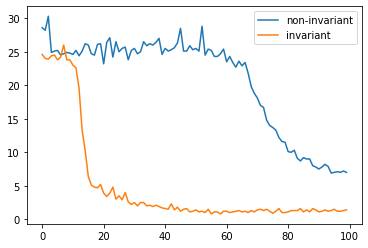

In [25]:
import matplotlib.pyplot as plt
plt.plot(np.arange(100),acc1,label='non-invariant')
plt.plot(np.arange(100),acc2,label='invariant')
plt.legend()